<img src="./img/ml_pipeline.png" alt="drawing" width="650"/>

In [107]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris


warnings.filterwarnings("ignore")


iris_df = pd.DataFrame(load_iris()["data"],columns=load_iris()["feature_names"])
iris_df["target"] = load_iris()["target_names"][load_iris()["target"]]

titanic_df = sns.load_dataset('titanic')

diamonds_df = sns.load_dataset('diamonds')

boston_df = pd.read_csv('data/HousingData.csv').drop(columns = 'Unnamed: 0')

<a id="carga_datos"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# 1. Carga datos

#### Tipo de archivos
Los más típicos [csv, txt, tsv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), [Excel (xlsx, xls)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html), [json](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html), [html](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_html.html) o [xml](https://pypi.org/project/pandas-read-xml/)

Ten en cuenta que **el csv puede tener distintos separadores**, los datos del Excel pueden estar en una **hoja concreta**, y en una combinación de filas/columnas diferente al origen de la hoja. También podemos acceder a los archivos a través de **una URL**. Se usan las mismas funciones de pandas.

Se recomienda abrir el csv en texto plano para ver el separador.

```Python
import pandas as pd

df = pd.read_csv("folder/file.csv", sep=";")
df = pd.read_csv("folder/file.csv", sep="\t")
df = pd.read_excel("folder/file.csv", sheet_name="Sheet1")
df = pd.read_json("folder/file.json")

URL = "https://raw.githubusercontent.com/guipsamora/pandas_exercises/master/02_Filtering_%26_Sorting/Euro12/Euro_2012_stats_TEAM.csv"
df = pd.read_csv(URL)
```

#### Encoding de los datos

<details>
<summary>Descripción de encoding</summary>
<p>
    
Los strings se almacenan internamente en un conjunto de bytes, caracter a caracter. Esta operación es lo que se conoce como *encoding*, mientras que pasar de bytes a string sería *decoding*. Bien, ¿y eso en qué nos afecta? Dependiendo del encoding, se suelen almacenar los caracteres en un espacio de bits de 0 a 255, es decir, en esa combinación de bits tienen que entrar todos los caracteres del lenguaje.

El problema es que en toda esa combinación de bits no entran todos los caracteres del planeta, por lo que dependiendo del encoding que usemos, una combinación de bits significará una cosa u otra. Por ejemplo, una A mayuscula será lo mismo en el encodig europeo que en el americano, pero los bits reservados para representar una Ñ, en el encodig americano se traduce en otro caracter.
    
</p>
</details>

#### ¿Qué dificultades podemos encontrar?

- **En la lectura tengamos un error de encoding**. Habrá que modificar el parámetro `encoding`, adaptándolo al archivo.

- **El archivo ya se ha creado con el encodig erróneo**. Tendremos caracteres raros en algunas palabras. Un mapeo y sustitución podría valer para solventar el problema.

- **Encontrar el encodig del archivo**. Es complicado saberlo antes de leer los datos. Aquí tenemos varios opciones:
    - Leer con Python e ir probando los más habituales (`unicode`, `utf-8`, `latin1`, `ANSI`). Todas las [funciones de lectura de pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) tienen el tipo de encoding como argumento
    - Abrir el archivo con el bloc de notas. El encoding viene en la esquina inferior derecha.
    <details>
    <summary>Ver imagen</summary>
    <img src="./img/encoding.png" alt="drawing" width="400"/>
    </details>
    - Usar la librería [`chardet`](https://pypi.org/project/chardet/) para saber el encoding adecuado del archivo.
    


#### ¿Cuántos DataFrames hay que cargar? train/test
Simplemente, dos opciones:

- **Todo el dataset junto**: necesitas un conjunto de test. Verás en el apartado <a href="#split_train_test">donde se divide en train y test</a> cómo hacer esta división.

- **Train/test por separado**: si tu conjunto de test no está etiquetado (tipico submission file de Kaggle), tendrás que proceder como en el punto anterior. En caso contrario ya tendrás definido tu conjunto de test, y el de train será el set de datos utilizados para el *cross validation* de los modelos.

#### Join de datos
No siempre tenemos los datos en un único dataframe, por lo que habrá que unir varios conjuntos de tal manera que haya una columna identificadora única para cada fila, con sus features y target asociados. **¿Cómo procedemos?**

1. **Identifica las claves de cruce**: Cuando juntas dos tablas necesitas al menos una columna en común en ambas, por ejemplo un id de cliente. Para que si en una tabla tienes datos de pedidos y en otra datos personales del cliente, mediante su id, podrás juntar toda esa información en una misma tabla.
2. **Escoge todas las columnas que vas a unir**: no siempre quieres quedarte con todos los datos de ambas tablas, por lo que habrá que elegir los datos a conservar de cada una.

```Python
left = df_pedidos[['id_cliente', 'pedido', 'descripcion']]
right = df_cliente[['id_cliente', 'dirección', 'edad']]

result = pd.merge(left, right, how='inner', on=['id_cliente'])
```

Describir cómo son los joins no es el objetivo de este notebook, pero te dejo [este enlace](https://realpython.com/pandas-merge-join-and-concat/) un buen artículo con varios ejemplos de joins.
<details>
<summary>Ver tipos de joins</summary>
<img src="./img/joins.jpg" alt="drawing" width="500"/>
</details>

#### ¿Me vale esta muestra para entrenar al modelo?
Es muy sencillo cuando tenemos un dataset cerrado, que viene de un concurso de Kaggle, pero en un caso real eso se cumple pocas veces. Hay muchas bases de datos en la empresa, por no hablar de todos los sitios externos (web scraping o APIs) de donde podemos sacar datos. ¿Cómo sabemos que tenemos los datos suficientes para montar un modelo? Si vamos a obtener nuevos, ¿a qué fuentes acudo? ¿cómo es la calidad de estos datos?

1. **Volumen**: Lo primero, necesitamos un buen volumen de datos. Menos de mil observaciones suele ser escaso para entrenar y testar un modelo de machine learning.
2. **Calidad**: la calidad de los datos siempre que mejor que cantidad. Es mejor encontrar unas pocas features predictivas, cuyos datos sean fiables, que una gran cantidad de features que no aporten nada al modelo. Asegúrate de que los datos conseguidos son buenos y no están manipulados, ni modificados por otros integrantes de la empresa. Y de ser así, si vas a utilizarlos piensa que cuando realices predicciones, las entradas de tu modelo tendrán que ser esos mismos datos modificados. 

3. **Caso de uso**: piensa en el problema de negocio y planteate qué variables podrían ser predictivas, y si es factible conseguir esos datos.
4. **Población**: asegúrante de que la población/muestra utilizada para entrenar se asemeje a la población con la que harás predicciones. Por ejemplo, si creas un modelo de tratamiento de imágenes, con el que predigas si unos pulmones tienen cáncer o no, tu modelo no tendrá un buen performance si lo entrenas con muestras de pulmones asiáticos y pretendes predecir muestras de pulmones caucásicos. O si entrenas solo con pulmones de mujeres e intentas predecir sobre pulmones de hombres.
5. **Fuentes externas**: si tienes tiempo planteate acudir a fuentes externas a la empresa, mediante APIs, datasets de kaggle, páginas del gobierno... Por otro lado, no incluyas datos en el entrenamiento que luego no vayas a conseguir para las predicciones. Por ejemplo, si consigues una muestra concreta de datos que publicó una empresa, y ya no se van a publicar más, cuando vayas a hacer predicciones, no vas a poder contar con esos datos. Por último, piensa también que cuantas más fuentes externas, más dependencias tendrá tu modelo para realizar las predicciones y quizá no sea sencillo conseguir ese dato.

6. **Crea tus propios datos**: ¿no tienes datos? "*invéntatelos*". Si necesitas crear un software de reconocimiento de imágenes para saber si alguien lleva gafas o no, saca fotos de amigos o familiares y utilizalas para el modelo. Otra opción es realizar encuestas.

<a id="reg_clas"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# 2. Problema Machine Learning
Existen varios tipos de problemas supervisados de machine learning. Este notebook se centra en problemas de clasificación y regresión, sin series temporales ni RRNN.

<img src="./img/ml_types.png" alt="drawing" width="650"/>

#### Algoritmos supervisados
Tenemos los datos etiquetados
1. **Clasificación**: el target del problema es un conjunto de valores discretos. Dos opciones:
    - Binaria: paga/no paga, fuga de cliente/no fuga, contrae enfermedad/no contrae
    - Multiclase: clasificar fruta (manzanas, peras, naranjas...), vinos (tinto, blanco, rosado)
2. **Regresión**: el objetivo es predecir una variable continua como: distancia, temperatura, ingresos.

#### Algoritmos no supervisados
Los datos no están etiquetados. Es el propio algoritmo el que detecta patrones en los datos y los separa.
1. **Clustering**: separación automática en grupos, como por ejemplo segmentación de clientes
2. **PCA**: reducción de dimensionalidad

Dentro de la clasificación anterior tendríamos los casos especiales de regresión con series temporales, o clasificación de imágenes/video con redes neuronales. **Este notebook se centra en clasificación y regresión de datos tabulares**.

Es MUY IMPORTANTE conocer el tipo de problema de Machine Learning porque va a ser determinante para toda la analítica que viene a continuación.

<a id="split_train_test"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# 3. Divide en train y test

En todo problema de machine learning hay que reservar una porción de los datos para probar nuestros modelos. Es imposible saber a priori qué modelo y qué configuración es la que mejor se ajusta a nuestros datos, por lo que tendremos que probar varias combinaciones (entrenar con train) y después probar con test qué modelo da menos errores, y así elegir.

<details>
<summary><b>Cómo funciona el train_test_split</b></summary>
<p>
Los dos primeros argumentos son features y target. Dos cosas importantes. Lo primero, tienen que coincidir en dimensión, y lo segundo acuérdate de quitar el target en el conjunto de las features. Después especificamos la proporción de los datos que reservaremos para test (0-1).

La división entre train y test la realiza mediante un muestreo aleatorio. Si tenemos un problema de clasificación binaria y los datos están ordenados de manera ascendente según el target, si simplemente nos quedamos con los primeros 70% para train y el resto, 30%, para test, caerán todos los 0s en train y todos los 1s en test. Por esta razón se realiza un muestreo aleatorio.
    
Por último, el argumento random_state. Como el muestreo es aleatorio, en cada ejecución tendríamos resultados diferentes. Fijando un número cualquiera conseguimos que el muestreo aleatorio que realiza siempre sea el mismo, de manera que si compartimos el notebook con otra persona o lo ejecutamos en otra ocasión, realizará el mismo split. Si queremos un split diferente simplemente habrá que poner otro número en el argumento random_state.
</p>
</details>


**¿Cuánto reservamos para test?** Entre un 15-30% es buena cifra.


In [108]:
X_train, X_test, y_train, y_test = train_test_split(boston_df.drop('MEDV', axis=1),
                                                    boston_df['MEDV'],
                                                    test_size=0.2,
                                                    random_state=42)

Realmente hay que dividir los datos en train, validation y test (ver imagen abajo). El conjunto de validation lo utilizamos para escoger modelo, y el de test para comprobar que nuestro modelo escogido generaliza bien. De momento vamos a preocuparnos de **guardar unos datos para test, y no los tocaremos hasta el final. No podemos contaminar train con los datos de test**. Esto supone seguir ciertas normas:

1. **Scalers**: por ejemplo, si tenemos un StandardScaler en train, usar ese mismo StandardScaler en test (ver ejemplo abajo).
2. **Outliers**: Me temo que los outliers no los voy a poder eliminar en test ya que en un problema real, podria entrar un outlier como input del modelo una vez hayamos hecho la puesta en producción. Cuidado con eliminar registros si estamos en una competición de Kaggle porque la cantidad de muestras que van a test no puede variar.
3. **Missings**: si aplicábamos la media/mediana/moda en train, aplicar esa misma métrica en test. No apliques la media de test en train.
4. **Feature reduction**: eliminar las features que quitábamos en train.
5. **Feature engineering**: mismos cálculos que en train.

**NOTA**: si se trata de un concurso de Kaggle, en el que ya te dan el conjunto de test aparte, no hace falta que dividas tu train para obtener un nuevo conjunto de test, sobre todo si tienes pocos datos. Utiliza todo el conjunto de train en el *cross validation* para escoger el mejor modelo, y después el test proporcionado por Kaggle para realizar una submission.

<img src="./img/train_test_split.png" alt="drawing" width="600"/>

In [109]:
# Ejemplo de código para un StandardScaler
from sklearn.preprocessing import StandardScaler

# Almaceno en el objeto scaler todo lo necesario para estandarizar, con los datos de train
scaler = StandardScaler()
scaler.fit(X_train)

# Utilizo los datos de train para escalar train y test.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<a id="target"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# 4. Target
Tenemos que echar un pequeño vistazo al target ya que hay ciertas casuísticas que no queremos tener, como por ejemplo un dataset desbalanceado o un target asimétrico. 

|Problema ML| Caso deseado | Caso no deseado |
|---|----|----|
|Clasificación| Dataset balanceado| Dataset desbalanceado|
|Regresión| Distribución normal| Distribución asimétrica|

#### Clasificación
Si intentamos predecir si una persona va a padecer un cáncer o no, y entrenamos un modelo en el que el 97% de los casos no ha padecido cáncer, si el modelo predice siempre que no tiene cáncer, conseguirá un 97% de precisión. Y no es lo que estamos buscando. Queremos profundizar más en ese 3%, y que el modelo sepa discriminar bien entre una clase u otra. **Esto es lo que se conoce como dataset desbalanceado**. Lo ideal es que el dataset esté lo más equilibrado posible. ¿Cómo lidiar con ello?
1. **Cambiando la métrica**: recall, f1-score o ROC curve (ver apartado de métricas).
2. **Consiguiendo más datos**: Parece una tontería pero muchas veces ni nos lo planteamos
3. **Resampling**: poner más copias del target con menor cantidad (over-sampling) o al revés (under-sampling), quitar datos del caso con mayor cantidad de datos. Under-sampling está bien cuando tenemos muchos datos, mientras que over-sampling lo tendremos que considerar cuando sean escasos. Prueba varios ratios.
4. **Generar datos sintéticos**: existen funciones de sklearn que son capaces de generar nuevos datos, como SMOTE (Synthetic Minority Over-sampling Technique)
5. **Prueba nuevos algoritmos**: los árboles de decisión suelen funcionar bien en problemas desbalanceados.
6. **Penalización en los modelos**: modelos que presten más atención a la clase minoritaria.
7. **Weights**: Es posible aplicarle un peso diferente a cada clase, para que esté más balanceadas, para ello usamos el parámetro *class_weight*.



In [110]:
from sklearn.ensemble import RandomForestClassifier

In [111]:
# !pip install imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

df = pd.read_csv("data/balance-scale.csv", index_col='Unnamed: 0')

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(df.loc[:, 'B':'1.3'], df['balance'])

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(df.loc[:, 'B':'1.3'], df['balance'])

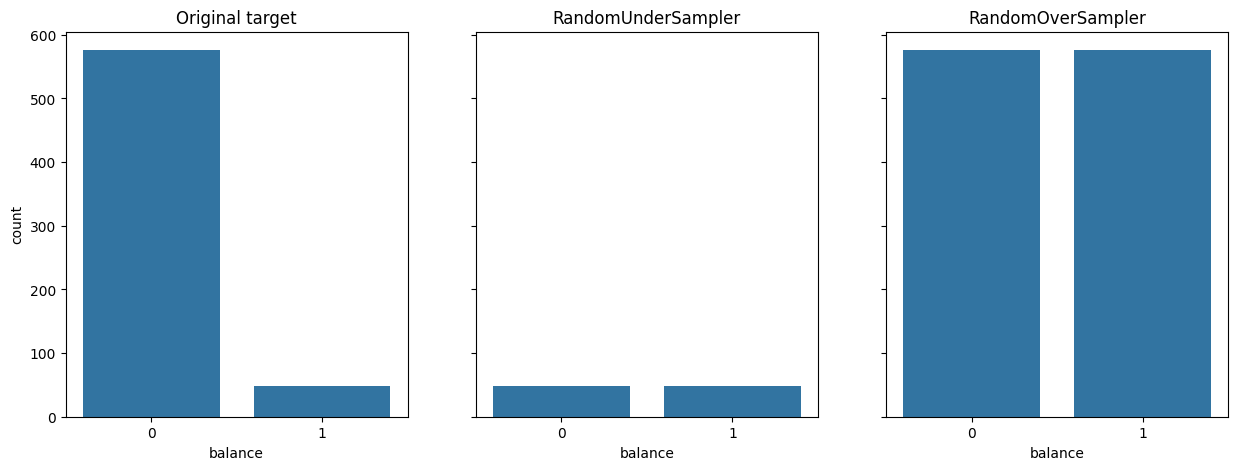

In [112]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Original target
sns.countplot(x="balance", data=df, ax=axes[0])
axes[0].set_title("Original target")

# RandomUnderSampler
sns.countplot(x = y_rus, ax=axes[1])
axes[1].set_title("RandomUnderSampler")

# RandomOverSampler
sns.countplot(x = y_ros, ax=axes[2])
axes[2].set_title("RandomOverSampler");

**Algunas consideraciones antes de utilizar esta técnica**
- Nunca testear sobre el conjunto sampleado. Siempre sobre el conjunto de test original 
- Si realizamos CrossValidation, siempre samplear DURANTE el CrossValidation, no antes. Es decir, meterlo en el Pipeline.

#### Regresión
Lo mejor para los modelos es que tengamos todos los datos escalados y con una distribución normal. Algunos de los algoritmos asumen ese tipo de distribuciones en los datos como las regresiones lineales o las redes neuronales. Ya que esto rara vez ocurre, hay que transformar las variables. Para estandarizar una distribución podemos aplicar varios tipos de transformaciones <a href="#feat_engi">(ver apartado transformaciones)</a>:

1. Logaritmica
2. Box-cox
3. Cuadrado/cúbica

Después puedes comprobar cuánto de normal es una variable mediante el **test de Saphiro** o un **Q-Q plot**.

<details>
<summary><b>Q-Q plot</b></summary>
<p>
Esta gráfica compara la variable en sí con respecto a una función de distribución gausiana estándar. Cuanto más se acerque a una línea recta, más estándar será la variable. Normalmente en el centro suele parecerse, pero se desvia por alguno de los lados. Eso quiere decir que tiene alguna asimetría.
<br>

<img src="./img/qqplot.png" alt="drawing" width="400"/>


</p>
</details>

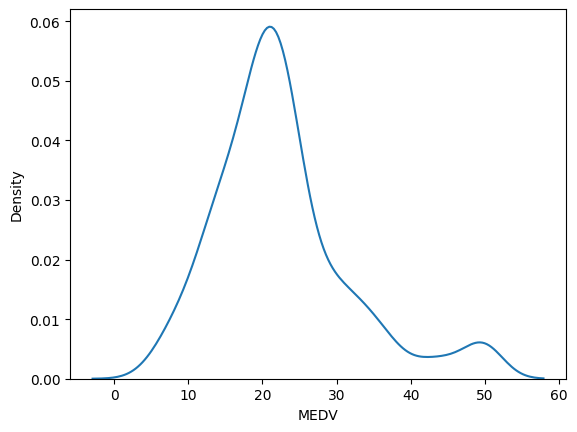

In [113]:
boston_target = boston_df['MEDV']
sns.kdeplot(boston_target);

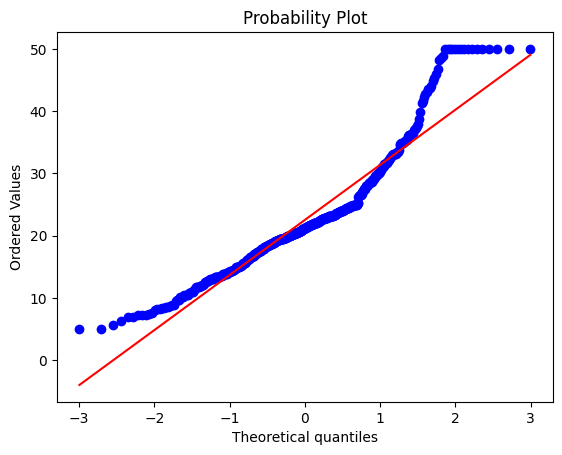

In [114]:
import numpy as np 
import pylab 
import scipy.stats as stats

stats.probplot(boston_df['MEDV'], dist="norm", plot=pylab)
pylab.show()

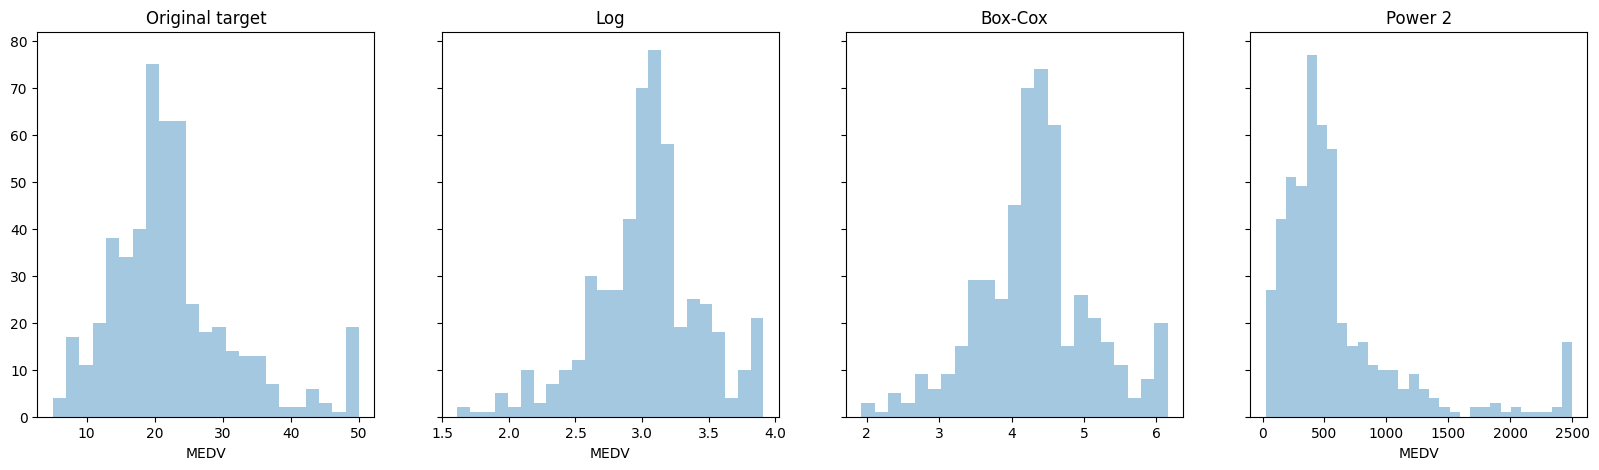

In [115]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# Original target
sns.distplot(boston_target, kde=False, ax=axes[0])
axes[0].set_title("Original target")

# Logaritmic
sns.distplot(np.log(boston_target),kde=False, ax=axes[1])
axes[1].set_title("Log")

# Box-cox
sns.distplot(stats.boxcox(boston_target)[0],kde=False, ax=axes[2])
axes[2].set_title("Box-Cox");

# Power 2
sns.distplot(np.power(boston_target, 2),kde=False, ax=axes[3])
axes[3].set_title("Power 2");

**NOTA**: Después de aplicar una de estas transformaciones, habrá que volver a aplicar las transformaciones inversas sobre las predicciones. Si aplicamos logaritmo, luego irá `np.expm()`, box-cox con `scipy.special.inv_boxcox()` y la raíz enésima, en el caso de elevar a la potencia enésima.

<a id="data_compr"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# 5. Comprensión de variables
<img src="./img/dtypes.png" alt="drawing" width="600"/>

Antes de ponernos a programar tenemos que entender muy bién cuál es la problemática y de qué datos disponemos, ya que este momento puede ser un punto de inflexión importante. Quizá con un pequeño análisis previo nos demos cuenta de que no hace falta un modelo de machine learning para solventar nuestro problema, o que no tenemos sufientes datos para realizar las predicciones planteadas inicialmente.


Realiza una pequeña analítica de cada una de las variables. Esta analítica puede ir perfectamente en un Excel y nos va a ayudar a comprender la naturaleza de las variables y el sentido de las mismas respecto al target. Deberás recabar la siguiente información:
1. **Variable**: nombre variable/alias
2. **Data type**: cualitativa, cuantitativa, ordinal, continua...¿?
3. **Segmento**: clasificar las variables según su significado. Si son variables demográficas, económicas, identificadores, tiempo...
4. **Expectativas**: un pequeño indicador personal de si resultará útil la variable. ¿Necesito esta variable para la solución? ¿Cómo de importante será esta variable? ¿Esta info la recoge otra variable ya vista?
5. **Conclusiones**: después del análisis anterior, llegar a unas conclusiones sobre la importancia de la variable.

**¿Por qué hacemos esto?** Si nuestro problema tiene muchas features, realizar una selección "a ojo" puede resultar muy útil, siempre y cuando se haga con criterio de negocio. Además, podría darse el caso de empezar el EDA pre-modelo erróneamente sin darnos cuenta, y este pequeño análisis nos servirá para orientarnos ante discrepancias durante el análisis y posibles rectificaciones tempranas.

Típicos métodos para echar un primer vistazo al dataset:

In [116]:
# Estadísticos
diamonds_df.describe()
diamonds_df.describe(include='all')

# Tipos de los datos
diamonds_df.dtypes

# Tipos de los datos y missings
diamonds_df.info()

# Columnas del dataset
diamonds_df.columns

# dimensiones del dataset
print("Filas:", diamonds_df.shape[0])
print("Columnas:", diamonds_df.shape[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB
Filas: 53940
Columnas: 10


### Forzar el data type
Fuerza los tipos de los datos. Si sabes que un float es un float, un str es un str, fuérzalo en el código para evitar errores posteriores. Hay que tener bien identificados los tipos de los datos.

Por supuesto, probablemente haya missings en los datos. La conversión de estos missings da error, pero lo solventamos (de momento) con el argumento `errores='ignore'`.

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 624 entries, 0 to 623
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   B        624 non-null    object
 1   1        624 non-null    int64 
 2   1.1      624 non-null    int64 
 3   1.2      624 non-null    int64 
 4   1.3      624 non-null    int64 
 5   balance  624 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 34.1+ KB


In [118]:
from seaborn import load_dataset
df = load_dataset('titanic')

# Diccionario con tipo en clave y valor columnas
new_types = {
    int: ['survived', 'age'],
    float: ['fare'],
    str: ['embarked', 'embark_town'],
    bool: ['alone']
}

for key, value in new_types.items():
    for i in value:
        df[i] = df[i].astype(key, errors='ignore')

# df['fare'] = df['fare'].astype(float)

#### Reporte de variables
Un pequeño reporte de las columnas, con sus tipos, % de missings y cardinalidad, resultará muy útil a lo largo de la analítica.

In [119]:
def data_report(df):
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T
        
data_report(df)

COL_N,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
DATA_TYPE,int32,int64,object,float64,int64,int64,float64,object,category,object,bool,category,object,object,bool
MISSINGS (%),0.0,0.0,0.0,19.87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.22,0.0,0.0,0.0
UNIQUE_VALUES,2,3,2,88,7,7,248,4,3,3,2,7,4,2,2
CARDIN (%),0.22,0.34,0.22,9.88,0.79,0.79,27.83,0.45,0.34,0.34,0.22,0.79,0.45,0.22,0.22


<a id="feat_red_prelim"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# 6. Feat. Red. Preliminar
En ocasiones es casi imposible llevar a cabo un análisis exploratorio si tienes una gran cantidad de features. Si ese es tu caso, deberías seguir alguna de las recomendaciones de este apartado.

Básicamente lo que haremos es eliminar algunas features. ¿Qué criterios seguiremos?
1. **Muchos missings**: a partir de un 40% de missings son features dificilmente salvables.
2. **Features repetidas**: columnas repetidas. Asegúrate bien de que sea así.
3. **Identificadores**: ids, nombres únicos. Son features que no aportan nada
4. **Feature selection**

    4.1 **Correlación lineal**: coeficientes de Pearson entre [-0.1, +0.1] respecto a nuestro target, suelen ser variables que no tiene nada que ver con el mismo.
    
    4.2 **Feature importance**: podemos tirar un modelo rápidamente que nos de la importancia de cada feature respecto al target: RandomForest se suele usar.
    
    4.3 **Varianza**: variables que no tienen varianza no nos interesan. El caso extremo sería una constante. No nos aporta nada. Es útil para ver que las variables pueden servir para el modelo pero no nos da una relación con el target.
    
    4.4 **Estadísticos**: la función de sklearn `SelectKBest` permite aplicar un test estadístico entre el target y cada uno de las features para determinar qué variables están relacionadas.

En este momento lo que se pretende es eliminar features que sabes con certeza que son muy inútiles, por lo que los criterios para eliminar features en este punto del análisis serán mucho menos restrictivos que en posteriores (no queremos cargarnos información sin conocer bien el dataset). De momento, será suficiente con seguir los puntos 1, 2 y 3. El punto 4 se aplicarán si la cantidad de features es muy grande, por ejemplo más de 50 features.

<details>
<summary><b>¿Qué es la correlación lineal?</b></summary>
<p>
    
La correlación, también conocida como coeficiente de correlación lineal (de Pearson), es una medida de regresión que pretende cuantificar el grado de variación conjunta entre dos variables.

Por tanto, es una medida estadística que cuantifica la dependencia lineal entre dos variables, es decir, si se representan en un diagrama de dispersión los valores que toman dos variables, el coeficiente de correlación lineal señalará lo bien o lo mal que el conjunto de puntos representados se aproxima a una recta.
    
Se trata de un valor normalizado entre [-1, 1]. Cuanto más cerca de 1, mayor es la relación lineal creciente enter dos variables. Si nos acercamos a -1, tienen na relación lineal inversa fuerte (según aumenta una variable, disminuye otra), y cuanto más se acerca a 0, menor es la relación entre las variables.
    
<img src="./img/correlation.jpg" alt="drawing" width="600"/>
    
</p>
</details>

<details>
<summary><b>¿Qué es el feature importance de un modelo?</b></summary>
<p>
Se trata de una serie de técnicas (depende de cada modelo) que asigna un score de importancia predictiva a las features de un modelo. Este score indica la importancia relativa de cada feature para la realización de las predicciones.
    
Estas técnicas son muy útiles por dos motivos:
* Comprender qué variables han influenciado más en la predicción del target
* Ver cuáles son las variables que tienen mayor relación con el target antes de correr cualquier modelo. Esto nos puede servir para hacer una primera preselección.
</p>
</details>

**Te recomiendo que utilices la función del apartado de comprensión de variables para elimar las que sean identificadores o tengan muchísimos missings**
#### Muchos missings

In [120]:
df = pd.read_csv('data/data with missings.csv')

precent_missing = df.isnull().sum()*100/len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                'percent_missing': precent_missing}).sort_values('percent_missing', ascending=False)
missing_value_df

,column_name,percent_missing
PoolQC,PoolQC,99.520548
MiscFeature,MiscFeature,96.301370
Alley,Alley,93.767123
Fence,Fence,80.753425
MasVnrType,MasVnrType,59.726027
...,...,...
ExterQual,ExterQual,0.000000
Exterior2nd,Exterior2nd,0.000000
Exterior1st,Exterior1st,0.000000
RoofMatl,RoofMatl,0.000000


In [121]:
cols_to_drop = missing_value_df[missing_value_df['percent_missing'] > 30].index.values
print("Cols:", cols_to_drop)

print("Columnas pre drop:", len(df.columns))

df.drop(columns=cols_to_drop, inplace=True)

print("Columnas post drop:", len(df.columns))

Cols: ['PoolQC' 'MiscFeature' 'Alley' 'Fence' 'MasVnrType' 'FireplaceQu']
Columnas pre drop: 81
Columnas post drop: 75


#### Correlación lineal

In [122]:
df = pd.DataFrame(boston_df.iloc[:, :-1],columns= boston_df.columns[:-1])
df["target"] = boston_df['MEDV']

# Borra las columnas con una correlacion menor a 0.2
corr = np.abs(df.corr()['target']).sort_values(ascending=True)
print(corr)

bad_corr_feat = corr[corr <0.2].index.values
print(bad_corr_feat)

df.drop(columns = bad_corr_feat, inplace = True)

CHAS       0.175260
DIS        0.249929
B          0.333461
ZN         0.360445
AGE        0.376955
RAD        0.381626
CRIM       0.388305
NOX        0.427321
TAX        0.468536
INDUS      0.483725
PTRATIO    0.507787
RM         0.695360
LSTAT      0.737663
target     1.000000
Name: target, dtype: float64
['CHAS']


#### Feature importance RandomForest

In [123]:
from sklearn.ensemble import RandomForestRegressor

import numpy as np
#Load boston housing dataset as an example
X = boston_df.drop(columns= 'MEDV')
Y = boston_df['MEDV']
names = X.columns
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X, Y)

scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
pd.DataFrame(scores, columns=['Score', 'Feature'])

,Score,Feature
0,0.4371,RM
1,0.3706,LSTAT
2,0.0602,DIS
3,0.0391,CRIM
4,0.0269,NOX
5,0.0156,PTRATIO
6,0.0147,TAX
7,0.0136,AGE
8,0.0107,B
9,0.0058,INDUS


#### Feature importance estadístico

In [124]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression

print(X.shape)
sel = SelectKBest(f_regression, k=5)
X_new = sel.fit_transform(X, Y)
print(X_new.shape)
print(sel.scores_)

pd.DataFrame({'column': names, 'score': sel.scores_}).sort_values('score', ascending=False)

(506, 13)
(506, 5)
[ 89.48611476  75.2576423  153.95488314  15.97151242 112.59148028
 471.84673988  83.47745922  33.57957033  85.91427767 141.76135658
 175.10554288  63.05422911 601.61787111]


,column,score
12,LSTAT,601.617871
5,RM,471.846740
10,PTRATIO,175.105543
2,INDUS,153.954883
9,TAX,141.761357
4,NOX,112.591480
0,CRIM,89.486115
8,RAD,85.914278
6,AGE,83.477459
1,ZN,75.257642


In [125]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48


In [126]:
X_new

array([[  2.31 ,   6.575, 296.   ,  15.3  ,   4.98 ],
       [  7.07 ,   6.421, 242.   ,  17.8  ,   9.14 ],
       [  7.07 ,   7.185, 242.   ,  17.8  ,   4.03 ],
       ...,
       [ 11.93 ,   6.976, 273.   ,  21.   ,   5.64 ],
       [ 11.93 ,   6.794, 273.   ,  21.   ,   6.48 ],
       [ 11.93 ,   6.03 , 273.   ,  21.   ,   7.88 ]])

<a id="univariant"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# 7. Análisis univariante
Antes de meternos de lleno con los modelos, tenemos que realizar un análisis exploratorio para comprender qué datos tenemos entre manos.

**¿Qué buscamos con este análisis?**
1. Comprobar que las variables tienen sentido y sus unidades de medida también son correctas
2. Detectar outliers
3. Detección de errores en la variable
4. Posibles features a eliminar
5. Detectar distribuciones extrañas. Buscamos siempre distribuciones normales en los datos. Es como mejor trabajan los modelos. Si las distribuciones no son normales, habrá que transformarlas <a id="#feat_engi">(ver apartado transformaciones)</a>.

**¿Qué hacemos si tenemos muchas variables en el dataset?** Si es el caso, deberíamos utilizar una matriz de correlación o correr algún modelo para que nos de un indicador de qué features serán las más predictivas. Podemos empezar por esas features. Otra manera de decidir qué features escoger es mediante un análisis de negocio. Si vas a predecir si un paciente padece una enfermedad, o la temperatura que hará mañana, o la probabilidad de fuga de un cliente en una telco, piensa qué variables necesitarías en un modelo de ese estilo, y cuáles de las que disponen cumplen con esos criterios.

<details>
<summary><b>Tipos de gráficas</b></summary>
<p>
    
Para representar una sola variable se utilizan las siguientes opciones:

    1. Box plot: está bien para ver la dispersión y outliers, pero no representa con exactitud la distribución.

    2. Función de densidad: funciona bien para ver la forma de su distribución, su asimetría e incluso outliers, pero el eje no está en unidades de la variable, sino en probabilidades.

    3. Histograma: Parecido a la función de densidad. En este caso cada barra nos da un conteo. Muy útil. Se suele combinar con la función de densidad.

    4. Violin plot: Parecido a la caja, pero en este caso representa también la distribución.
    
En resumen, los que más se suelen utilizar son los histogramas y diagramas de caja.
</p>
</details>


<details>
<summary><b>Gráficas en función de tus datos</b></summary>
<p>
    
La representación individual de la variable resulta muy útil ya que nos da información de outliers, asimetría y dispersión. Pero como el objetivo es predecir el target, relacionar la variable con el target siempre aportará información enriquecedora ya que podremos ver relaciones entre cada variable vs el target. Por ello, llevaremos a cabo diferentes representaciones en función de los dos tipos de problemas planteados en este notebook:

    1. Clasificación, feature numérica: podemos representar la feature en un diagrama de densidad (o histograma), en varios colores, dependiendo de la categoría del target.

    2. Clasificación, feature categórica: representa en un diagrama de barras un conteo de valores. Puedes añadirle un color a cada barra en función del target.

    3. Regresión, feature numérica: un scatter plot de ambas variables.

</p>
</details> 

#### Clasificación, feature numérica

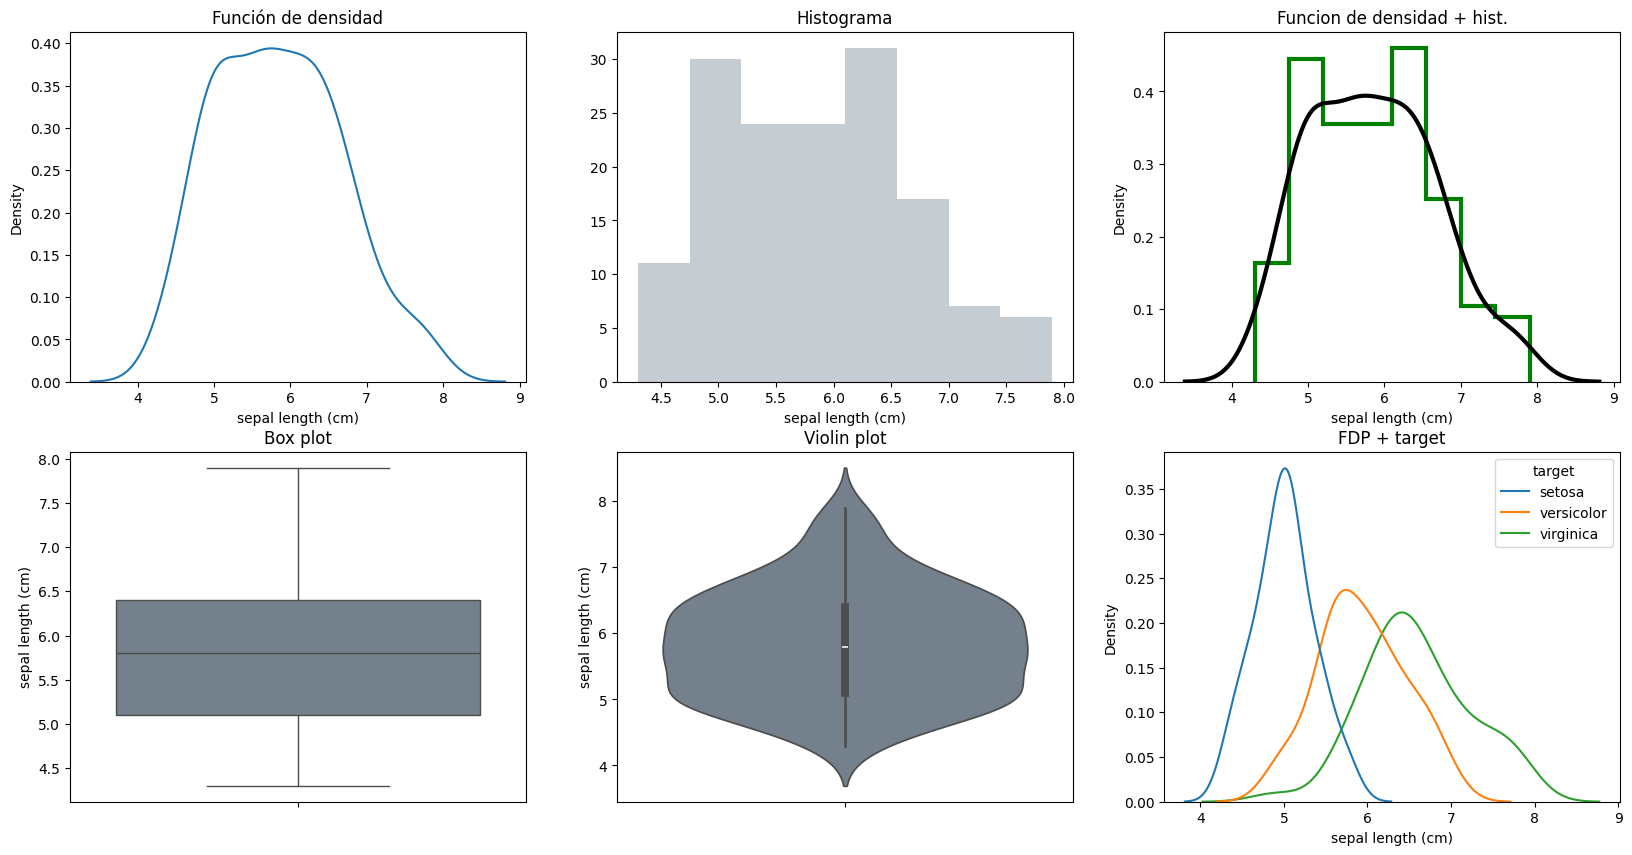

In [127]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Funcion de densidad
sns.distplot(iris_df['sepal length (cm)'], hist = False, ax=axes[0, 0])
axes[0, 0].set_title("Función de densidad")

# Histograma
sns.distplot(iris_df['sepal length (cm)'],
             kde=False,
             color='slategray',
             ax=axes[0, 1]);

axes[0, 1].set_title("Histograma")

# Funcion de densidad + histograma
sns.distplot(iris_df['sepal length (cm)'],
            kde_kws={"color": "k", "lw": 3, "label": "KDE"},
            hist_kws={"histtype": "step", "linewidth": 3,
                      "alpha": 1, "color": "g"},
             ax=axes[0, 2])


axes[0, 2].set_title("Funcion de densidad + hist.")

# Boxplot
sns.boxplot(iris_df['sepal length (cm)'], color="slategray", ax=axes[1, 0])
axes[1, 0].set_title("Box plot")

# Violin plot
sns.violinplot(iris_df['sepal length (cm)'], color="slategray", ax=axes[1, 1])
axes[1, 1].set_title("Violin plot")


# Funcion de densidad + target
sns.kdeplot(data=iris_df, x='sepal length (cm)', hue = 'target', ax=axes[1, 2])
axes[1, 2].set_title("FDP + target");

#### Clasificación feature categórica

In [128]:
len(titanic_df["survived"])

891

In [129]:
titanic_df["embark_town"]

0      Southampton
1        Cherbourg
2      Southampton
3      Southampton
4      Southampton
          ...     
886    Southampton
887    Southampton
888    Southampton
889      Cherbourg
890     Queenstown
Name: embark_town, Length: 891, dtype: object

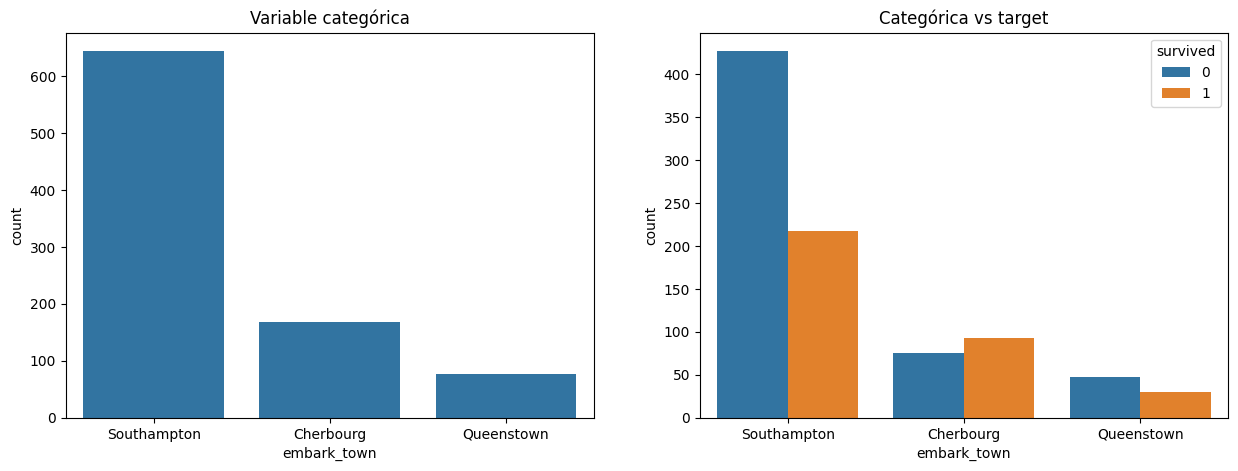

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Conteo de categorica
sns.countplot(x = titanic_df["embark_town"], ax=axes[0])
axes[0].set_title("Variable categórica")

# Categorica vs target
sns.countplot(x = titanic_df["embark_town"], hue=titanic_df['survived'], ax=axes[1], dodge=True)
axes[1].set_title("Categórica vs target");

#### Regresión (numérica y categórica)

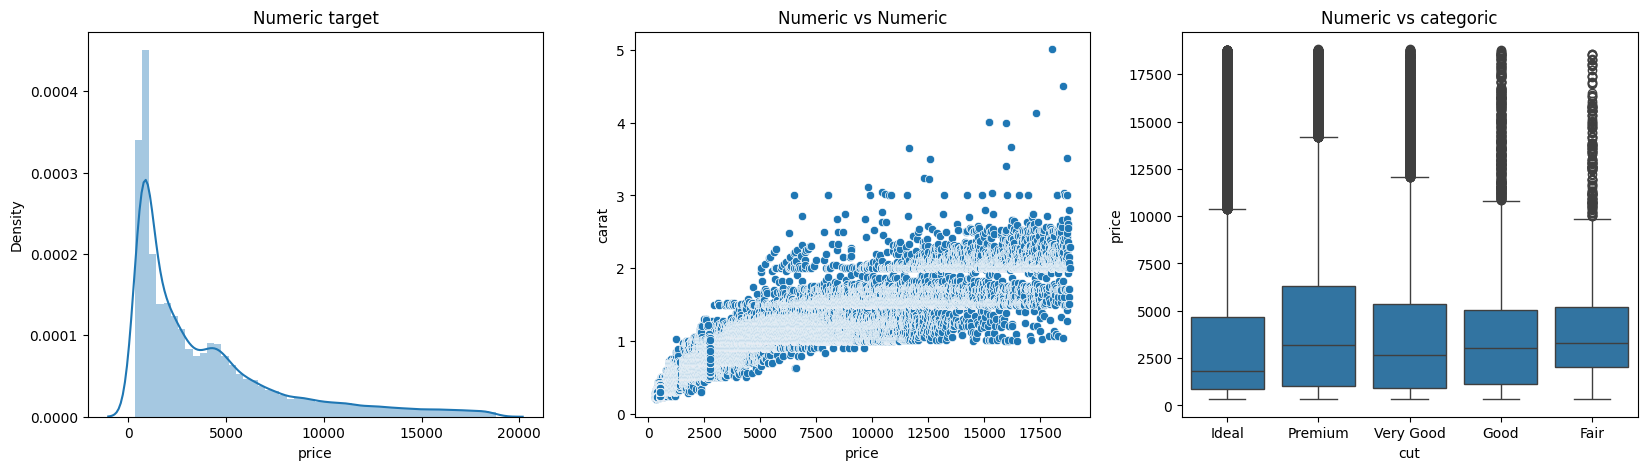

In [131]:
# Target de precio en el dataset de diamonds
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Numeric target
sns.distplot(diamonds_df['price'], ax = axes[0])
axes[0].set_title("Numeric target")

# Numeric vs Numeric
sns.scatterplot(x = diamonds_df['price'], y = diamonds_df['carat'], ax = axes[1])
axes[1].set_title("Numeric vs Numeric")

# Categorica vs target
sns.boxplot(data=diamonds_df, x='cut', y='price', ax=axes[2])
axes[2].set_title("Numeric vs categoric");

#### Código para análisis rápido univariante

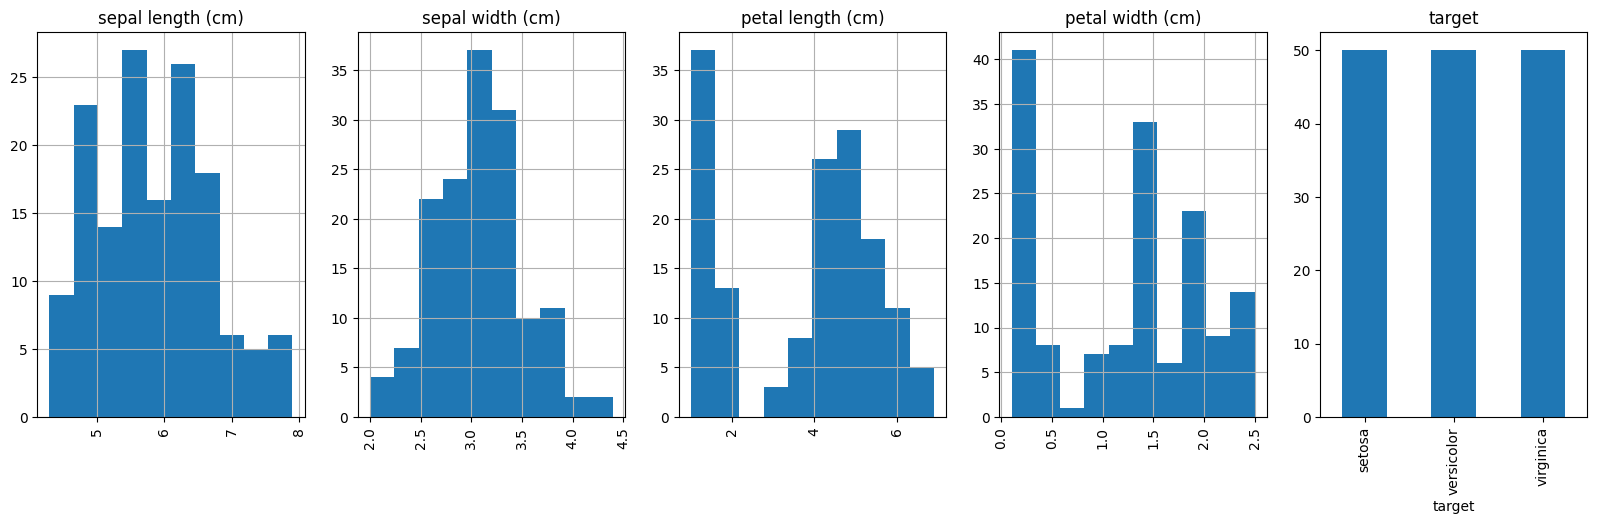

In [132]:
fig = plt.figure(figsize=(20, 5))
cols = 5
rows = int(np.ceil(float(iris_df.shape[1]) / cols))
for i, column in enumerate(iris_df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if iris_df.dtypes[column] == np.object_:
        iris_df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        iris_df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

<a id="bivariant"></a>  
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
## 8. Análisis bivariante
Utilizamos este tipo de análisis para ver cómo son las relaciones entre nuestros datos, dos a dos. Los objetivos de este análisis son:
1. **Relación con el target**: ver qué tipo de relación hay entre cada feature con el target. Con el tipo de relación intuiremos el modelo que mejor le vendrá a nuestros datos.
2. **Eliminar algunas features**: comprobar si hay features con una alta correlación lineal entre ellas. Eso significa dos cosas:
    - Si hay dos features que se parecen mucho, sobra una. ¿Cuál? La que tenga mas missings o menor correlación con el target
    - Si dos features tienen una correlación lineal alta podemos sufrir de multicolinearidad. Te dejo [este artículo](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/#:~:text=Multicollinearity%20occurs%20when%20independent%20variables,model%20and%20interpret%20the%20results.) para más información.

Podemos llevar a cabo dos tipos de anális bivariante, uno mediante visualizaciones, y otro con tests y medidas estadísticas. Las visualizaciones serían el método más artesanal de ver esas relaciones entre los datos, mientras que con las medidas estadísticas puedo establecer un criterio algo más automatizado.

#### ¿Qué visualizaciones puedo hacer?
Lo mejor es hacer un grid de scatterplots. Suena muy rimbombante, pero en seaborn no es más que una línea de código. Resulta útil si tenemos todo variables numéricas, pero para categóricas no nos vale, tendremos que acudir a tablas y diagramas de barras stacked o agrupadas.

#### ¿Qué medidas estadísticas puedo utilizar?
Lo habitual es utilizar el coeficiente de pearson (lo que te da una matriz de correlación) para cada dos variables, ya que es un valor normalizado entre [-1, 1]. Si el valor está en torno a 0, las dos variables tienen muy poca correlación lineal, y cuanto más cercano a 1 o -1 mejor será su correlación lineal directa o inversa respectivamente. A partir de +/- 0.6 o 0.7 suele ser una buena correlación. No obstante un coeficiente de pearson alto [no siempre asegura una buena relación entre los datos](https://www.tylervigen.com/spurious-correlations)

El problema viene cuando queremos ver relaciones entre variables categóricas. En este caso ya no es tan útil el coeficiente de pearson. **Para detectar este tipo de relaciones recomiendo utilizar el coeficiente de Phik o Cramér's V**. En la [documentación de pandas profiling](https://github.com/pandas-profiling/pandas-profiling) tienes algunos ejemplos.

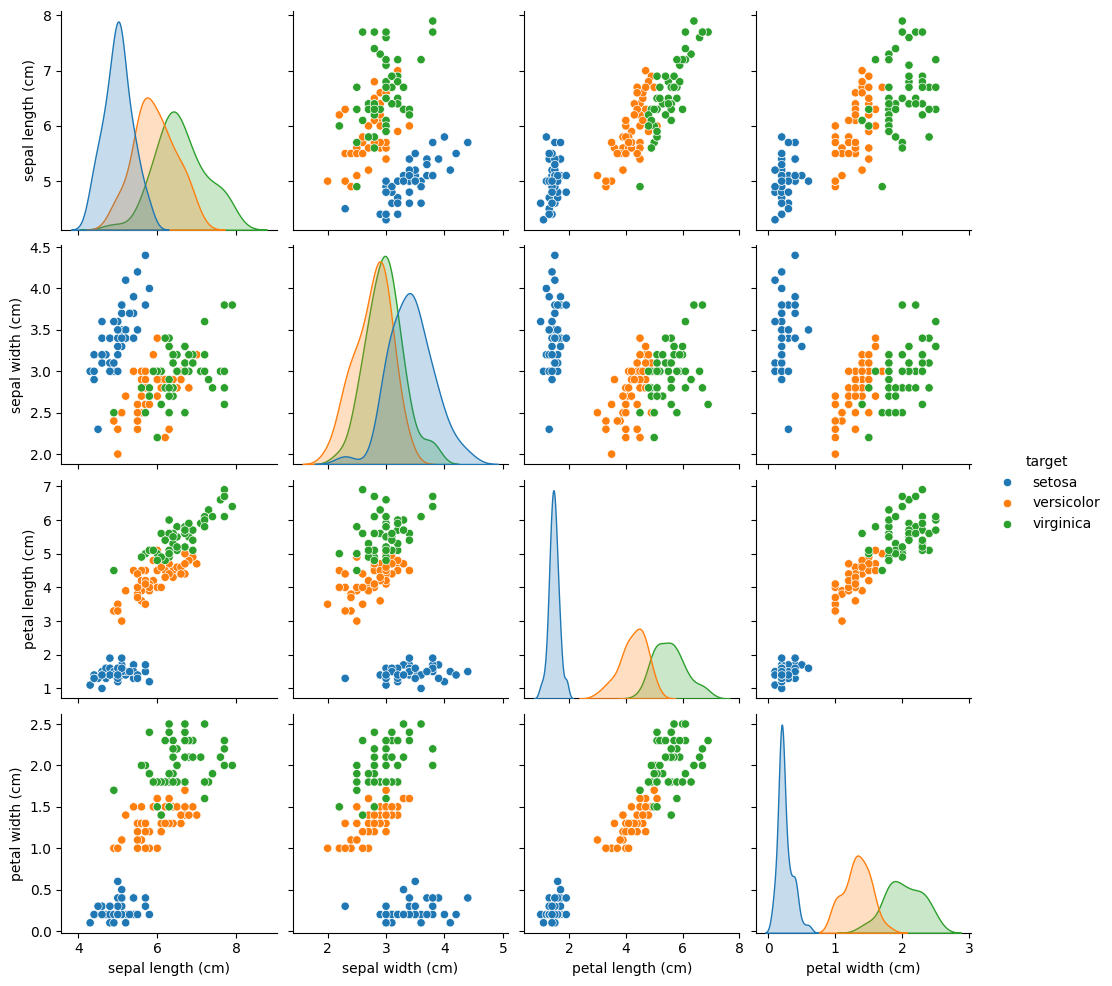

In [133]:
# Variables numericas vs target categórico
sns.pairplot(iris_df,
            kind='scatter',
            hue='target');

In [134]:
# Categórica vs categorica
pd.crosstab(titanic_df['survived'],
           titanic_df['sex'])

sex,female,male
survived,,
0,81,468
1,233,109


In [135]:
titanic_df.groupby(['embarked', 'survived']).size().reset_index().pivot(columns='embarked', index='survived', values=0)

embarked,C,Q,S
survived,,,
0,75,47,427
1,93,30,217


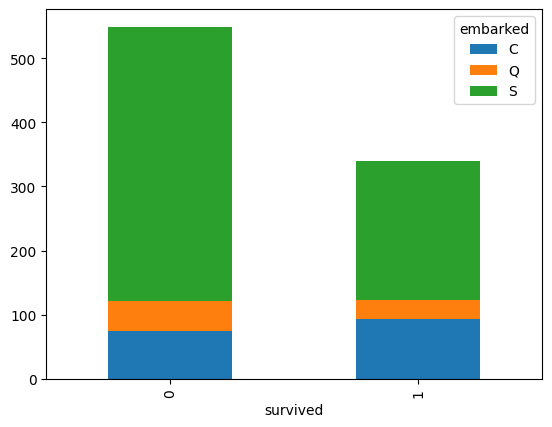

In [136]:
df_plot = titanic_df.groupby(['embarked', 'survived']).size().reset_index().pivot(columns='embarked', index='survived', values=0)
df_plot.plot(kind='bar', stacked=True);

#### Correlation matrix/heatmap

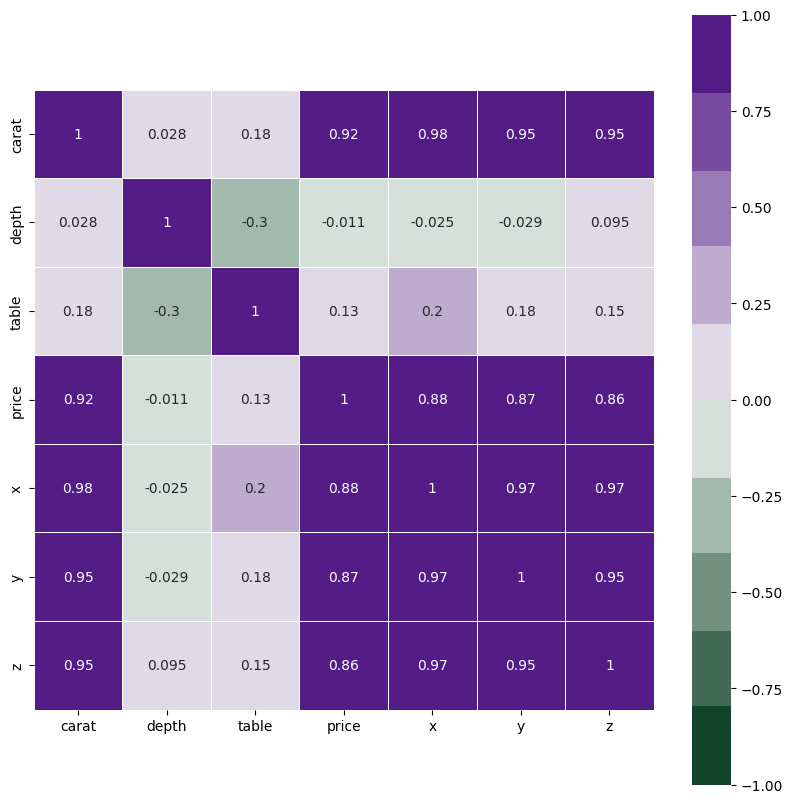

In [137]:
# Establece los límites de colores entre [-1, 1], así como un rango de colores de oscuro a oscuro, pasando por claro (0 correlación)
plt.figure(figsize=(10,10))
sns.heatmap(diamonds_df.corr(numeric_only=True),
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
            square=True,
            annot=True,
            linewidths=.5);

#### Phik matrix/heatmap
Esta matriz es un muy buen indicador sobre la relación entre los datos, teniendo en cuenta variables categóricas.

In [138]:
diamonds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


interval columns not set, guessing: ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']


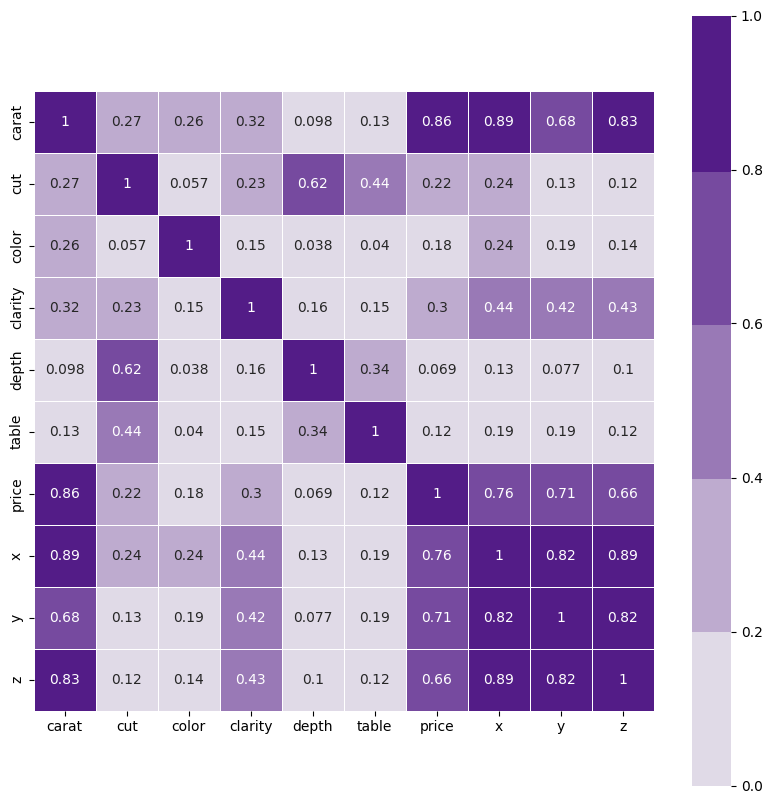

In [139]:
# !pip install phik
import phik
phik_matrix = diamonds_df.phik_matrix()

plt.figure(figsize=(10,10))
sns.heatmap(phik_matrix,
            vmin=0,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
            square=True,
            annot=True,
            linewidths=.5);

<a id="del_features"></a>     
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
## 9. Eliminación de features
Una vez hecho un primer análisis de nuestras variables, llega el momento de limpiar el dataset. Lo primero que nos planteamos es si sobran features, en función de toda la información ya recabada. Parecido al primer apartado de eliminación de features, pero en este caso no seremos tan restrictivos, ya que eliminaremos features con más información de la que disponíamos antes.
* **Features con valores constantes**.
* **Features con alto porcentaje de missings**: En general más de un 20%-30% de missings en una sola feature es bastante, por lo que podría considerarse la eliminación de la misma.
* **Features con identificadores**. Todo lo que sean ids y nombres tienen poco poder predictivo. Podría darse el caso de que un id correle mucho con una fecha. Sería el caso de pedidos de una empresa, cuyo id va aumentando según pasan los días, pero igualmente suele aportar poco.
* **Features de strings largos**: Se podría aplicar algún tratamiento de texto con expresiones regulares o incluso NLP (Natural Language Processing), pero en general suelen eliminarse este tipo de features.
* **Features categóricas con alta cardinalidad**: viene a ser parecido a los identificadores. Se suelen eliminar.
* **Correlación o Phik matrix**: podríamos aplicar estos indicadores para eliminar algunas features. Recuerda que la matriz de correlción sólo te da información sobre la relación LINEAL entre los datos numéricos.

Estas decisiones no se toman tampoco a la ligera y dependerá mucho de la cantidad de features que tengamos disponible. Si es poca, andaremos con más cuidado a la hora de eliminar información, mientras que si son muchas las features no habrá problema en eliminar algunas tipo identificador o que contengan gran cantidad de missings.

```Python
# Elimina features pero no sustituye
df.drop(columns=['feature1', 'feature2'])

# Elimina features y sustituye en el dataframe
df.drop(columns=['feature1', 'feature2'], inplace=True)
```

In [165]:
# Con este código podrás eliminar de manera automática features con mucha cardinalidad o gran cantidad de missings

# Max (%) cardinalidad que permitiremos en una feature
cardi = 20

# Max (%) de missings que permitiremos en una feature
max_miss = 30

def drop_cols(df_, max_cardi=20, max_miss=30):
    df = df_.copy()
    delete_col = []
    
    for i in df.columns:
        missings = df[i].isnull().sum() * 100 / len(df)
        
        # Elimina por missings
        if missings >= max_miss:
            df.drop(columns=i)
            continue
        
        # Elimina por cardinalidad en variables categoricas
        if df[i].dtype.name in ('category', 'object'):
            if df[i].nunique()*100/len(df) >= max_cardi:
                df.drop(columns=i)          
        
    return df

drop_cols(titanic_df).head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3.0,male,22.0,1.0,0.0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1.0,female,38.0,1.0,0.0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3.0,female,26.0,0.0,0.0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1.0,female,35.0,1.0,0.0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3.0,male,35.0,0.0,0.0,8.0500,S,Third,man,True,NaN,Southampton,no,True


<a id="duplicates"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
## 10. Duplicados
Datos duplicados en general no aportan nada, a no ser que hayamos remuestrado el target, en el caso de tener un dataset desbalanceado <a href="#target">(ver apartado de análisis del target)</a>. Por tanto, en general se suelen eliminar.

**¿Qué es un duplicado?** Pregunta obvia, pero en ocasiones no está tan claro. ¿Sabrías identificar cuál es tu clave única en los datos? Un identificador único puede ser los clientes, o los pedidos hechos en tu tienda, o tus pacientes. Pero si tu clave son tus clientes, podrías tener varios clientes "duplicados" porque dispones de datos concretos de ese cliente a fecha 14 y 15 de marzo. O tienes datos únicos de clientes, o tienes datos únicos por cliente y fecha, las dos cosas no puedes.

**¿Cómo elimino los duplicados?** Lo más fácil es un `drop_duplicates()` de pandas, que eliminará los registros duplicados teniendo en cuenta TODAS las columnas. Pero hay ocasiones en las que quiero eliminar registros duplicados en función de unas pocas columnas (ver ejemplo abajo).

**NOTA**: cuidado con eliminar datos en test si estamos en una competición de Kaggle. A la muestra de test no le podemos quitar registros

In [166]:
df1 = pd.DataFrame({'Clientes': ['Alba', 'Carolina', 'Alberto', 'Alberto'],
                   'Fecha': ['2020-01','2020-01','2020-01','2020-02'],
                   '¿Compró?': [1, 1, 1, 1]})
df1

,Clientes,Fecha,¿Compró?
0,Alba,2020-01,1
1,Carolina,2020-01,1
2,Alberto,2020-01,1
3,Alberto,2020-02,1


Alberto en principio está duplicado. Pero si aplico un drop duplicates no me lo elimina ya que TODAS las filas son únicas. Para ello habrá que decirle a pandas qué columna/as queremos que utilice para discrimiar si un registro es un duplicado o no. En este caso será únicamente el nombre. [Aqui tienes la documentación del drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

In [167]:
print("len original", len(df1))

print("len drop_duplicates():", len(df1.drop_duplicates()))

de_new = df1.drop_duplicates(subset = 'Clientes', keep = 'last')
print("len drop_duplicates() por cliente:", len(de_new))

len original 4
len drop_duplicates(): 4
len drop_duplicates() por cliente: 3


In [168]:
de_new

,Clientes,Fecha,¿Compró?
0,Alba,2020-01,1
1,Carolina,2020-01,1
3,Alberto,2020-02,1


<a id="missings"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
## 11. Missings
Suponen un problema ya que la mayoría de los modelos no saben tratar los missings y por tanto tendremos que inferir sus valores. Por aclarar, un missing no es un 0, ni un string vacío, ni un False. Es un hueco en los datos, el vacío, nos falta un dato en una de las features. Eso es un missing.

#### ¿Por qué aparecen missings?
* **Missings en la extracción de los datos**: estos se suelen identificar rápido, por ejemplo, que no se ha leido bien un CSV, y todos los valores se los tome como uno solo.
* **Missings completamente aleatorios**: la probabilidad de que haya un valor missing es la misma para todas las observaciones.
* **Missings aleatorios**: aleatoriamente hay missings en una columna. Por ejemplo, datos de edades de una pagina web, vemos que hay más missings de mujeres que de hombres.
* **Missings que dependen de los inputs**: Por ejmplo, en un estudio médico, si un diagnóstico es dudoso, hay una alta probabilidad de ser descartado. Cuando estos missings se les pone a "Dudoso", dejan de ser valores aleatorios.
* **Missings que dependen de su propio valor**: por ejemplo, ingresos de las personas, los que tienen mucho o muy poco, se tenderá a no poner el valor.
* **Missings en tratamiento de datos**: pueden aparecer missings debido a una incorrecta lectura o escritura, tratamiento de los datos y merge con otras tablas.

#### Métodos para tratar los missings
* **Imputación sobre caso similar**: tengo en cuenta otra variable, por ejemplo si tengo la altura de alumnos de una clase, podria calcular los missings teniendo en cuenta si son chicos o chicas. O si hay missings de densidad de población, pero tengo la población y el área, podría recalcularlo. Esta opción es lo ideal, razonando los missings con los propios datos.
* **Borrado**: Aquí hay dos opciones: si hay un missing en una columna, nos cargamos toda la fila. El borrado se realiza cuando tenemos pocos missings y muchas observaciones. De lo contrario, eliminaríamos muchos datos.
* **Imputación por valor concreto**: No es lo más habitual, pero puede ocurrir que sepamos de antemano por qué hay missings en esa feature. Quizá todos los días hay problemas en la carga de la base de datos con el carácter Ñ, y cuando debería aparecer España, en realidad está en missing. Este método también se utiliza cuando hay missings en la variable categórica, le ponemos un nombre genérico y equivaldría a añadir una categoría nueva a la feature.
* **Imputación de Media/Mediana/Moda**: es el método más frecuente, sobretodo si tenemos poco tiempo. Para variables numéricas imputamos normalmente la media, aunque si la variable tiene asimetría, suele dar mejores resultados la mediana. En el caso de que sea una variable categórica lo más habitual es utilizar la moda.
* **Imputacion + flag**: es igual que el caso anterior, pero además añadimos una nueva columna binaria por cada feature con missings imputados para indicarle al modelo que en ese lugar había un missing.
* **Modelo**: es lo más sofisticado. Dividimos el dataset en dos: uno con missings y el otro sin, que se usa para entrenar al modelo. Este método se suele comportar bien, a no ser que no tengan mucha relación los datos. Lo habitual es usar KNN, regresión logística o lineal. El KNN rellena los missings teniendo en cuenta el resto de variables del dataset, buscando similitudes con registros que tengan las variables parecidas. Se puede usar para cualitativas y cuantitativas, las variables con muchos missings se pueden tratar fácilmente. Lo malo es que es muy lento y la elección del k-value es crítica.

Vamos al código para imputar missings. Lo primero que necesitas saber es los missings que tienes en los datos. Para ello lo mejor es utilizar la función que hemos creado en el apartado de comprensión de variables

In [169]:
data_report(titanic_df)

COL_N,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
DATA_TYPE,int64,float64,object,float64,float64,float64,float64,object,category,object,bool,category,object,object,bool
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.22,0.0,0.0,0.0,77.22,0.22,0.0,0.0
UNIQUE_VALUES,2,3,2,112,7,7,248,3,3,3,2,7,3,2,2
CARDIN (%),0.22,0.34,0.22,12.57,0.79,0.79,27.83,0.34,0.34,0.34,0.22,0.79,0.34,0.22,0.22


In [170]:
# En los ejemplos con drop NO estamos sobreescribiendo el dataset

# Para eliminar una columna, si tiene muchos missings
iris_df.drop(columns = ['sepal length (cm)'])

# Eliminamos las filas si encuentra missing en cualquier columna del dataset
iris_df.dropna()

# Elimina las filas donde todos sus elementos sean missing
iris_df.dropna(how='all')

# Elimina filas si encuentra missings en las siguientes columnas
iris_df.dropna(subset=['sepal length (cm)', 'sepal width (cm)'])

# Imputar con un valor
iris_df['sepal length (cm)'] = iris_df['sepal length (cm)'].fillna(0)

# Imputar con la media o mediana
iris_df['sepal length (cm)'] = iris_df['sepal length (cm)'].fillna(iris_df['sepal length (cm)'].mean())
iris_df['sepal length (cm)'] = iris_df['sepal length (cm)'].fillna(iris_df['sepal length (cm)'].median())

# Interpolar. Imputa missings en función del valor anterior y el siguiente. Tendrá sentido en series temporales, es decir, con datos ordenados
iris_df['sepal length (cm)'] = iris_df['sepal length (cm)'].interpolate()

In [171]:
# Imputacion mediante KNN
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
imputer.fit(titanic_df[['pclass', 'age', 'sibsp', 'parch', 'fare']])
titanic_df[['pclass', 'age', 'sibsp', 'parch', 'fare']] = imputer.transform(titanic_df[['pclass', 'age', 'sibsp', 'parch', 'fare']])

In [172]:
data_report(titanic_df)

COL_N,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
DATA_TYPE,int64,float64,object,float64,float64,float64,float64,object,category,object,bool,category,object,object,bool
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.22,0.0,0.0,0.0,77.22,0.22,0.0,0.0
UNIQUE_VALUES,2,3,2,112,7,7,248,3,3,3,2,7,3,2,2
CARDIN (%),0.22,0.34,0.22,12.57,0.79,0.79,27.83,0.34,0.34,0.34,0.22,0.79,0.34,0.22,0.22


<a id="errors"></a> 
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
## 12. Anomalías y errores
También podemos encontrarnos casos extraños en los datos que no siempre se corresponden con un outlier. Un outlier es un valor atípico en una variable, pero que puede tener cierto sentido. Sin embargo, un error es un valor que no tiene nada que ver con la variable, como que aparezcan edades en negativo, o haya ciertos datos a 99999. También podría ocurrirnos en texto, un texto mal decodificado, o unas fechas erróneas. Posibles errores que habría que corregir:
1. **Numeros positivos que aparecen como negativos**: variables numéricas que siempre deberían tener numeros positivos y en algún caso (o en muchos) presente datos negativos, habrá que tratarlo como si fuesen missings.
2. **Datos de fecha incorrectos**: asegúrate que estás leyendo bien la fecha en el formato americano o europeo. Suele cambiarse la posición del día por la del mes. Comprueba que los años de las fechas son coherentes, ya que una lectura errónea puede llevar a fechas del año 9999. El método que no te va a fallar (pero tambiéne s el más costoso) es importar la fecha en string, y luego parsear cada uno de sus elementos mediante la función `split()`.
3. **Encoding del texto**: si ves caracteres raros, sospecha del encoding del texto. Abre el archivo de los datos en texto plano y comprueba que no tenga caracteres raros. Prueba varios encodings en la lectura. Los más habituales: ascii, ansi, utf-8, latin1. Tienes más información en <a href="#carga_datos">el apartado de carga de datos</a> 

<a id="outliers"></a>   
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
## 13. Outliers
#### ¿Qué es un outlier?
Se trata de un valor atípico dentro de nuestros datos. Un valor que se desvía mucho de las métricas estadísticas de centralidad (media, moda, mediana). En el análisis exploratorio de datos suele ser algo a estudiar, el por qué tengo algunos valores atípicos en los datos. No obstante, en machine learning los outliers en los datos implican penalizaciones en los modelos, sobretodo los que trabajan con distancias y con Gradient Descent. Por tanto, hay que lidiar con ellos.

#### ¿Cómo detecto los outliers?
Lo mejor es gráficamente, aunque también puedes parametrizar una serie de umbrales en tus features, a partir de los cuales consideras que son outliers. Hay dos maneras de verlos gráficamente, mediante análisis:
1. **Univariante**
2. **Bivariante**
3. **Medidas estadísticas**: cuánto me desvío de la media, o cuánto de lejos estoy del IQR.

#### ¿Qué gráficas utilizo para visualizar los outliers?
Lo mejor son boxplots, histogramas, diagramas de densidad, scatter plots y count plots para categóricas.

#### ¿Qué técnicas hay para detectar outliers?
1. **Gráficamente**: Datos que se desvien mucho.
2. **Cuartiles**: se ve en un diagrama de caja. Datos que caigan fuera del rango +/- 1.5*IQR. Este 1.5 es muy restrictivo por lo que se suelen probar valores del 3 al 5. Dependerá mucho de cada feature.
3. **Desviación estándar**: todo lo que caiga fuera de (media +/- N*std) de la variable. Normalmente N es un valor de 3 a 5.

Ten en cuenta siempre el contexto de negocio para considerar los outliers, no el puramente numérico. El propio negocio del dataset que estés analizando es el que define qué es un outlier y qué no.

Detectar gráficamente es la técnica más habitual, pero si quieres hacerlo de una manera más automatizada puedes probar con las otras dos opciones. Además ten en cuenta que **los outliers siempre dependen del negocio** por lo que deberás analizarlos bien antes de eliminarlos.

<img src="./img/boxplot.png" alt="drawing" width="600"/>    

<details>
<summary><b>Causas de los outliers</b></summary>
<p>
    
* **Entrada de datos**: errores humanos causados durante la recolección, como por ejemplo escribir 10.000 en vez de 1.000. Se comprueba fácil que esto es un outlier, comparándolo con los otros valores.
* **Errores de medida**: es el más común. Se producen cuando para los datos se han utilizado instrumentos de medida. Si tenemos 10 maquinas para medir el peso, es posible que una de ellas esté averiada.
* **Errores experimentales**: se han medido mal los datos en el propio experimento, no por el aparato de medida. Si hay 7 corredores esprintando y uno ha salido más tarde, su tiempo será mayor, pero realmente su tiempo de carrera no refleja este dato.
* **Errores intencionados**: suele relacionarse con reportes que incluyan datos personales.
* **Error en el procesado de datos**: en lo que cargamos los datos de varias fuentes, es posible que hayamos introducido algún error en el procesamiento de los datos.
* **Error en el muestreo**: se hayan introducido muestras de otro tipo en el dataset. Por ejemplo, estamos midiendo la altura de los alumnos de futbol, y se nos han colado algunos de basket.
* **"Errores" naturales**: cuando no es artificial. Es posible que sean así los datos.
    
</p>
</details>

#### ¿Qué hago con los outliers?
Tenemos varias opciones:
1. **Eliminarlos**: es la técnica más habitual y sencilla
2. **No hacer nada**: si no son exagerados. Los árboles de decisión y SVM (en este orden) son robustos frente a outliers.
3. **Transformaciones logarítmicas**: elimina asimetría en las features, y por tanto reduce el efecto de los outliers. Para más info<a href="#feat_engi"> ver el apartado de transformaciones.</a>
4. **Binning**: discretiza la variable en varios grupos. Esto me va a permitir incluir los outliers en un grupo donde haya otros datos no considerados como outiers (ver ejemplo abajo)
5. **Imputación**: igual que con los missings, sustituir los valores. Esto tendrá sentido si los outliers están bien analizados, y desde el punto de vista de negocio conviene sustituirlos por un valor concreto.
6. **Tratamiento por separado**: si es un número significativo de outliers quizá merezca la pena separar los datos y tratarlos como otro modelo aparte.

#### ¿Qué modelos son más sensibles a outliers?
Los modelos a los que MENOS afectan los outliers son los árboles de decisión, por lo que todo lo que sean árboles y derivados tendrán un comportamiento robusto frente a outliers. Los SVM también funciónan bien. A los algoritmos que más les afectan los outliers son a los basados en distancia (KNN) o Gradient Descent (regresiones).

**NOTA** Mucho cuidado al eliminar outliers en X_train. Hay que eliminar los mismos registro en el target (y_train). Para ello lo mejor es juntarlos, eliminarlos y cuando vayas a modelar separar X de y.

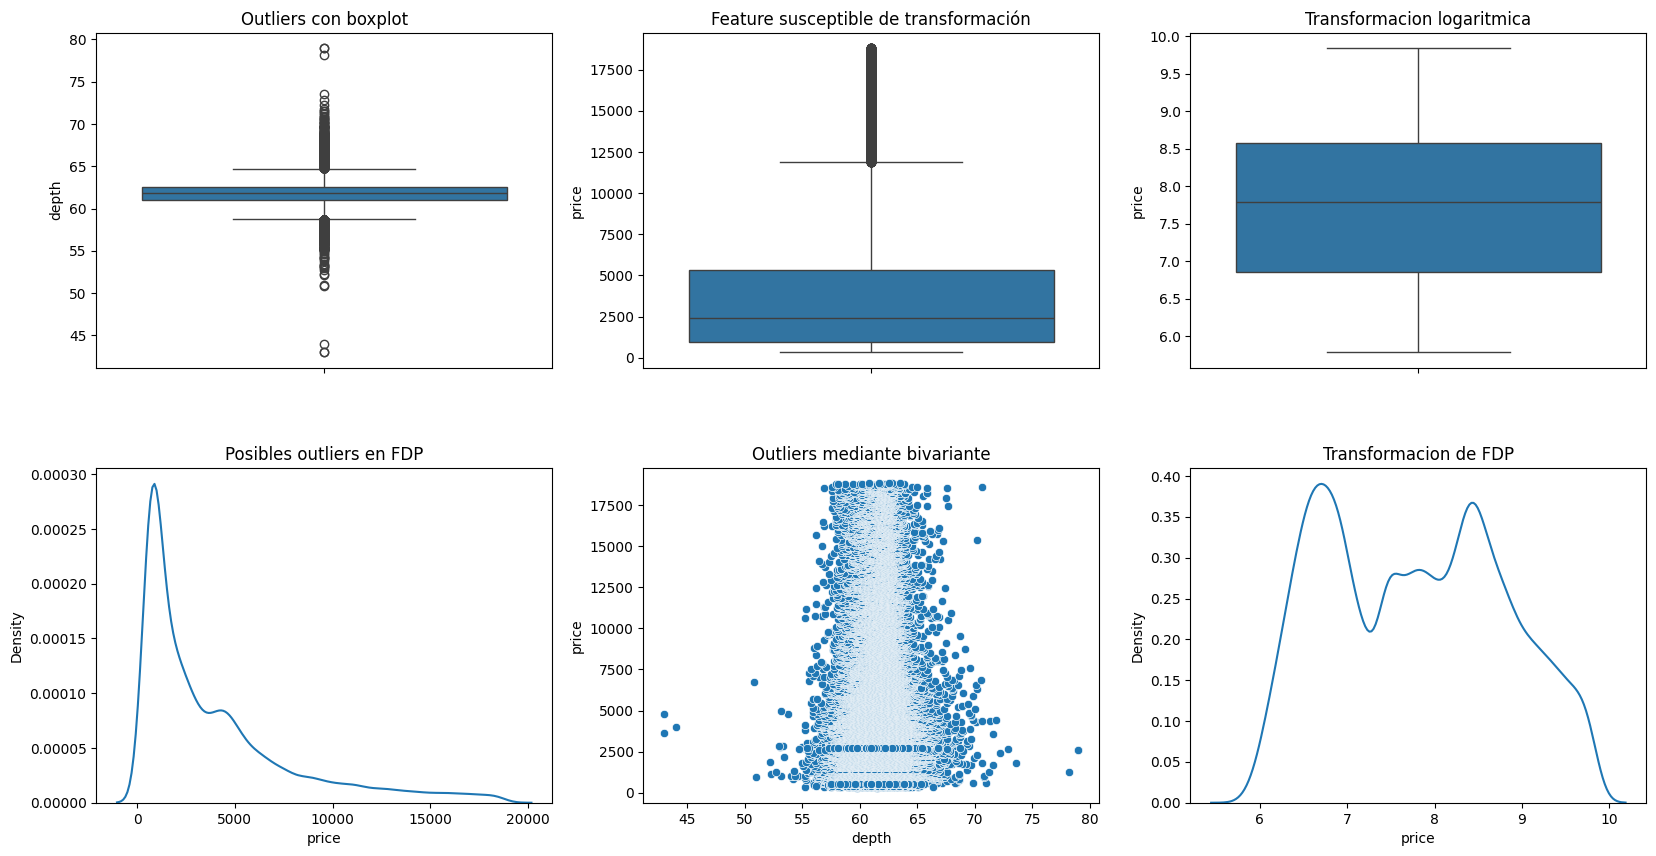

In [173]:
# Target de precio en el dataset de diamonds
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(hspace = 0.3)

# Outliers con boxplot
sns.boxplot(diamonds_df['depth'], ax=axes[0, 0])
axes[0, 0].set_title("Outliers con boxplot")

# Feature susceptible de transformación
sns.boxplot(diamonds_df['price'], ax=axes[0, 1])
axes[0, 1].set_title("Feature susceptible de transformación")

# Transformacion logaritmica
sns.boxplot(np.log(diamonds_df['price']), ax=axes[0, 2])
axes[0, 2].set_title("Transformacion logaritmica")

# Posibles outliers mediante FDP
sns.kdeplot(diamonds_df['price'], ax=axes[1, 0])
axes[1, 0].set_title("Posibles outliers en FDP")

# Outliers mediante bivariante
sns.scatterplot(data=diamonds_df, x='depth', y='price', ax=axes[1, 1])
axes[1, 1].set_title("Outliers mediante bivariante")

# Transformacion de FDP
sns.kdeplot(np.log(diamonds_df["price"]), ax=axes[1, 2])
axes[1, 2].set_title("Transformacion de FDP");

In [174]:
diamonds_df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Len original: 53940
Len sin outliers en depth: 51395


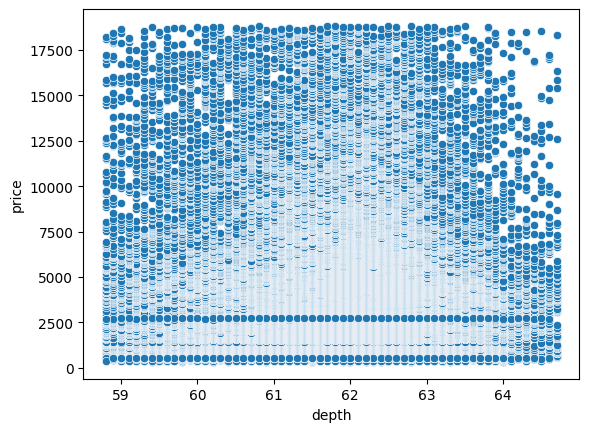

In [175]:
from scipy.stats import iqr

def outliers_quantie(df, feature, param=1.5):  
        
    iqr_ = iqr(df[feature], nan_policy='omit')
    q1 = np.nanpercentile(df[feature], 25)
    q3 = np.nanpercentile(df[feature], 75)
    
    th1 = q1 - iqr_*param
    th2 = q3 + iqr_*param
    
    return df[(df[feature] >= th1) & (df[feature] <= th2)].reset_index(drop=True)

diamonds_df2 = outliers_quantie(diamonds_df, 'depth', 1.5)
print("Len original:", len(diamonds_df))
print("Len sin outliers en depth:", len(diamonds_df2))
sns.scatterplot(data=diamonds_df2, x='depth', y='price');

In [176]:
diamonds_df['depth']

0        61.5
1        59.8
2        56.9
3        62.4
4        63.3
         ... 
53935    60.8
53936    63.1
53937    62.8
53938    61.0
53939    62.2
Name: depth, Length: 53940, dtype: float64

Len original: 53940
Len sin outliers en depth: 53739


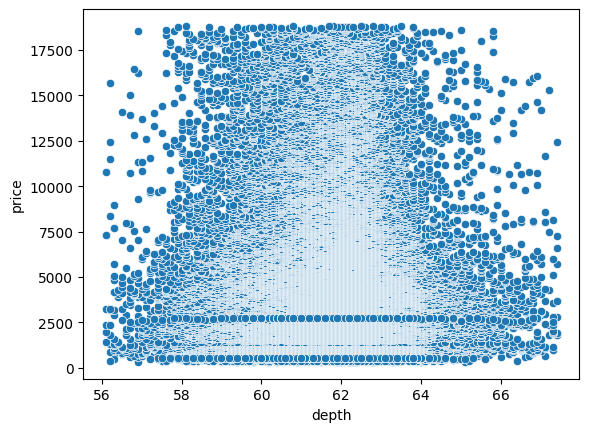

In [177]:
def outlier_meanSd(df, feature, param=3):   
    media = df[feature].mean()
    desEst = df[feature].std()
    
    th1 = media - desEst*param
    th2 = media + desEst*param

    return df[((df[feature] >= th1) & (df[feature] <= th2))  | (df[feature].isnull())].reset_index(drop=True)


diamonds_df2 = outlier_meanSd(diamonds_df, 'depth', 4)
print("Len original:", len(diamonds_df))
print("Len sin outliers en depth:", len(diamonds_df2))
sns.scatterplot(data=diamonds_df2, x='depth', y='price');

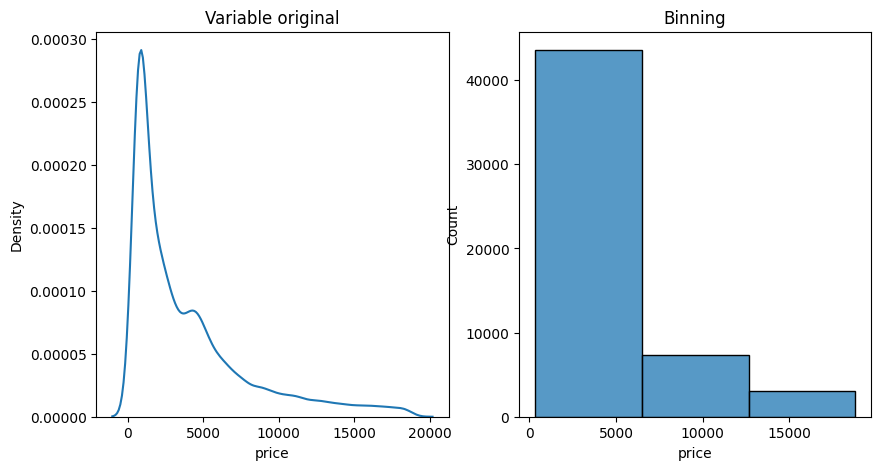

In [178]:
# Tecnicas de binning
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(hspace = 0.3)

sns.kdeplot(diamonds_df["price"], ax=axes[0])
axes[0].set_title("Variable original")

sns.histplot(diamonds_df["price"], bins=3, ax=axes[1])
axes[1].set_title("Binning");

In [179]:
hist, bin_edges = np.histogram(diamonds_df["price"], bins=3, density=True)
bin_edges

array([  326.        ,  6491.66666667, 12657.33333333, 18823.        ])

<a id="feat_engi"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# 14. Feature Engineering

### 14.1 Transformaciones
Como ya se ha mencionado varias veces a lo largo del notebook, lo ideal es tener distribuciones normales en todas las variables (target incluido) de un modelo. Por desgracia no siempre es así, y variables como el salario de una población suelen tener una larga cola hacia la derecha, es decir, presentan asimetría positiva.

#### ¿Cómo solucionamos esto?
Aplicando transformaciones logarítimicas, cuadradas o cúbicas. Las logarítimicas suelen dar mejor resultado.

Para comprobar si tenemos una distribución normal, lo mejor es graficarla, pero siempre tenemos la opción de calcular un valor numérico que nos indique si la distribución es normal o no. Para ello podemos aplicar el test de Shapiro, cuya hipótesis nula es que la variable sigue una distribución normal, mientras que la alternativa sostiene que no sigue una distribución normal. Si el p-value es mucho menor que su nivel de significación (0.05), tendremos que rechazar la hipotésis nula y asegurar que la variable NO sigue una distribución normal.

Otra forma de visualizar la normalidad de una variable es mediante un Q-Q plot
<details>
<summary><b>Q-Q plot</b></summary>
<p>
Esta gráfica compara la variable en sí con respecto a una función de distribución gausiana simétrica. Cuanto más se acerque a una línea recta, más normal será la variable. Normalmente en el centro suele parecerse, pero se desvia por alguno de los lados. Eso quiere decir que tiene alguna asimetría.
<br>

<img src="./img/qqplot.png" alt="drawing" width="400"/>


</p>
</details>

In [198]:
from scipy.stats import shapiro
from scipy.stats import skew

boston_target = boston_df['MEDV']
# Muy por debajo del nivel de significación (0.05) no se considera distribución normal.
print("Saphiro:", shapiro(boston_target).pvalue)

# Para comprobar la asimetría de una variable siempre podemos calcular su valor skew
# 0 si es simetrica, >0 cola hacia la derecha, <0 cola hacia la izquierda
print("Asimetria:", skew(boston_target))

Saphiro: 4.941386258635722e-16
Asimetria: 1.104810822864635


In [199]:
import seaborn as sns

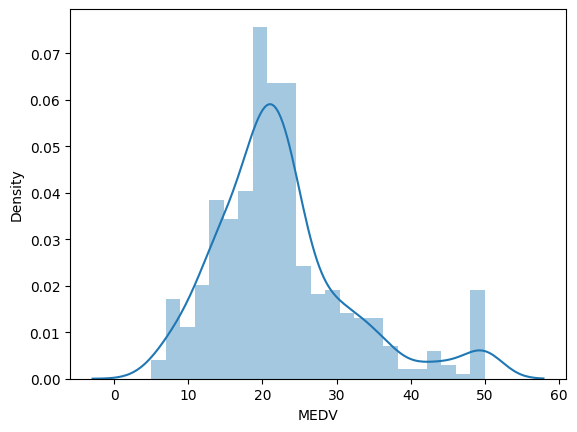

In [200]:
sns.distplot(boston_target);

p-value Shapiro test Original:  4.941386258635722e-16
Asimetria: 1.104810822864635
p-value Shapiro test Logaritmic:  1.9354268611078725e-07
Asimetria: -0.32934127453151935
p-value Shapiro test Box-cox:  2.0404639982680616e-06
Asimetria: 0.01583480314947703


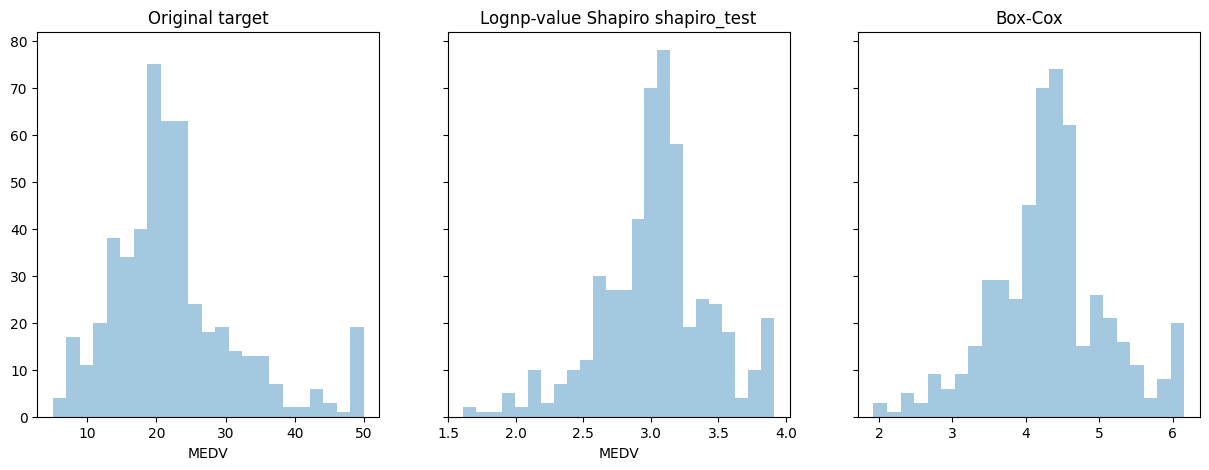

In [201]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Original target
print("p-value Shapiro test Original: ", shapiro(boston_target).pvalue)
sns.distplot(boston_target, kde=False, ax=axes[0])
axes[0].set_title("Original target")
print("Asimetria:", skew(boston_target))

# Logaritmic
print("p-value Shapiro test Logaritmic: ", shapiro(np.log(boston_target),).pvalue)
sns.distplot(np.log(boston_target),kde=False, ax=axes[1])
axes[1].set_title("Log" + 'np-value Shapiro ' +"shapiro_test")
print("Asimetria:", skew(np.log(boston_target)))

# Box-cox
print("p-value Shapiro test Box-cox: ", shapiro(stats.boxcox(boston_target)[0]).pvalue)
sns.distplot(stats.boxcox(boston_target)[0],kde=False, ax=axes[2])
axes[2].set_title("Box-Cox");
print("Asimetria:", skew(stats.boxcox(boston_target)[0]))

### 14.2 Encodings
¿En qué dataset no vamos a encontrar variables cualitativas? Variables categóricas que se componen de un conjunto de valores finito, pequeño, y normalmente en formato string. Aportan muchísima información, pero necesitamos transformarlas a valores numéricos para que los modelos puedan trabajar con ellas, ya que no admiten texto.

Una primera aproximación podría ser asignar un número del 1 a n a cada categoría, siendo n la cantidad de valores únicos de esa variable. Esto no es del todo correcto ya que si tuviésemos países en una variable y asignamos 1 a China, 2 a Marruecos y 3 a Brasil, estamos diciendo que China está a 2 de distancia de Brasil y que Marruecos es un país a medio camino entre China y Brasil. Estamos cometiendo un error y es que le estamos asignando un orden a variables que originalmente no tienen orden.

Por tanto, estas son las preguntas que deberías plantearte cuando vayas a codificar variables categóricas:

**¿La variable es binaria?** En este caso nos dará igual el orden. Asignamos 1 y 0 indistintamente y listo.

**¿La variable está ordenada?** Si estuviese ordenada, nuestra primera aproximación sería perfectamente válida. Eso sí, aplicando el mapeo correcto. Si tenemos calificaciones tipo ['Baja', 'Media', 'Alta', 'Muy Alta'], asegúrante de codificarlas en el orden correcto: [0, 1, 2, 3].

**¿Y si la variable no está ordenada?** Aplicaremos un dummy encoder o OneHotEncoder. Básicamente consiste en crear una columna nueva con cada feature. Todas las columnas a 0, excepto cuando aparezca esa categoría concreta. En ese caso pondremos un 1.
<details>
<summary><b>OneHotEncoder</b></summary>
<p>

<img src="./img/onehotencoder.jpg" alt="drawing" width="400"/>

</p>
</details>

Para más detalle sobre la diferencia entre un OneHot o dummy encoder visita [este enlace](https://stats.stackexchange.com/questions/224051/one-hot-vs-dummy-encoding-in-scikit-learn#:~:text=One%2Dhot%20encoding%20converts%20it,up%20with%20kn%2Dk%20variables.)

**¿Y si tenemos una gran cardinalidad en la variable?** No es muy viable aplicar un OneHot o dummy encoder, ya que crearía demasiadas features nuevas. Otra posible opción es emplear un HashingEncoder. Establecemos un número m de columnas, y traduce mediante una función hash todas las categorias de la feature en solo las m columnas, por supuesto ya no van a ser binarias. En [este enlace](https://medium.com/flutter-community/dealing-with-categorical-features-with-high-cardinality-feature-hashing-7c406ff867cb#:~:text=Feature%20hashing%20maps%20each%20category,within%20a%20pre%2Ddetermined%20range.&text=Convert%20data%20into%20a%20vector,or%20%E2%80%9Cthe%20hashing%20trick%E2%80%9D.) tienes información sobre cómo funciona.

**Consejos para trabajar con train y test**. Recuerda no contaminar train con los datos de test. Esto quiere decir que si usas un OneHotEncoder sobre una categoria de colores, donde en test hay colores que no tienes en train, NO crees columnas dummy de esos colores en train porque en teoría train no sabe que existen esos colores de test. Crea los dummies en train con los datos de train, y utiliza la misma codificación para test. Si alguna de las categorias de train no coincide con las de test y viceversa, simplemente aparecerá todo el registro a 0s.

| Método | Descripción |
|--------|-------------|
|DummyEncoding/OneHotEncoder|Sustituye la variable por 1s y 0s en varias columnas <br />Por sencillez, se recomienda usar la función de dummies de pandas, en vez del OneHotEncoder de sklearn|
|LabelEncoding|Sustituye cada categoria por un valor numérico creciente|
|Count encoding|Sustituye cada categoría por la frecuencia de aparición de la misma|
|Mean encoding|Para problemas de regresión. Sustituye cada categoría por la media del target para esa categoría|
|Hashing|Utilizado cuando tenemos una alta cardinalidad en los datos|

Los métodos mean encoding o el count encoding no son tan efectivos como el resto.

In [202]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

df = pd.DataFrame({'City': ['SF', 'SF', 'NYC', 'NYC', 'Seattle', 'Seattle'],
                   'Rent': [3999, 4000, 3499, 3500, 2499, 2500]})

dummy_df = pd.get_dummies(df, prefix=['city'])
dummy_df

,Rent,city_NYC,city_SF,city_Seattle
0,3999,False,True,False
1,4000,False,True,False
2,3499,True,False,False
3,3500,True,False,False
4,2499,False,False,True
5,2500,False,False,True


In [203]:
# Si queremos aplicar un mapeo personalizado
# Para encodig binario se recomienda aplicar un mapeo, para no equivocarnos.
def mapping(x):
    if x == 'SF':
        return 1
    elif x == 'NYC':
        return 2
    elif x == 'Seattle':
        return 3
    else:
        return 9999

df['Custom map'] = df['City'].apply(mapping)
df

,City,Rent,Custom map
0,SF,3999,1
1,SF,4000,1
2,NYC,3499,2
3,NYC,3500,2
4,Seattle,2499,3
5,Seattle,2500,3


In [204]:
# Si tenemos una alta cardinalidad en los datos, utilizamos un hasher
from sklearn.feature_extraction import FeatureHasher

df = pd.DataFrame({'CA': ['Madrid', 'Cataluña', 'Andalucia', 'Pais Vasco', 'Andalucia', 'Madrid', 'Valencia', 'Andalucia']})
df

,CA
0,Madrid
1,Cataluña
2,Andalucia
3,Pais Vasco
4,Andalucia
5,Madrid
6,Valencia
7,Andalucia


In [205]:
h = FeatureHasher(n_features=3, input_type='string')
h

FeatureHasher(input_type='string', n_features=3)

### 14.3 Nuevas features
Llega la parte más creativa de la analítica, en la que intentamos sacarle jugo a los datos. El objetivo de este apartado es crear nuevas features a partir de las que ya tenemos. Muy habitual cuando no tenemos muchas features y hay que buscar nuevas.

Algunas técnicas que podemos aplicar:
1. **Si tenemos fechas y horas**, podemos obtener nuevos datos como:
    - Año, trimestre, mes, dia, hora, minuto, segundo.
    - Un indicador de si es de dia o de noche. O incluso si es por la mañana, horario laboral...
    - Otro indicador de si es un dia de fin de semana o laboral.
    - Decadas o épocas.
2. **Concatenar campos**: si tenemos variables categóricas, puede resultar interesante realizar otras agrupaciones con otras categóricas. Por ejemplo, si tenemos ventas por cliente, segmentadas por sexo y tipo de producto. Una nueva feature puede ser combinar ambos, para tener un indicador agregado de tipo de producto y sexo.
3. **Agrupar**: sería el binning que ya hemos visto. Por ejemplo agrupar edades en varios bins.
4. **Suma/Resta/Multiplicación...**: los ratios suelen ser útiles. Cuidado con las combinaciones lineales entre variables, sobretodo si estamos con regresión lineal.
5. **Agregaciones de otros datasets**:  por ejemplo, si estamos viendo pedidos de clientes, sus datos agregados de lo que suelen gastar, o la media de pedidos que hacen al mes, se podrían añadir al dataset.
6. **Datos espaciales**: si tuviésemos varias localizaciones geográficas, podriamos calcular por ejemplo distancias.
7. **Texto**: podemos sacar info de ciertas palabras clave. Por ejemplo, si tenemos nombres con Mr, Mis, Mrs... es posible extraer la variable sexo de manera sencilla, empleando únicamente el nombre.
8. **Datos externos macro**: si estamos trabajando con paises o poblaciones, podemos agregar nuevos datos al dataset como el PIB, cantidad de población, distribución por sexo...acudiendo a fuentes como el INE.

### 14.4 Escalados
Dependiendo del modelo que vayamos a utilizar, resultará útil escalar las features. **¿Qué significa escalar una variable?**
Consiste en cambiar el orden de magnitud de la variable, conservando su distribución. Estas transformaciones se aplican por separado a cada feature. Se suele calcular unas métricas como media, desviación estándar, y mediante una fórmula aplicamos la transformación a cada valor de la feature.

#### ¿Por qué realizamos transformaciones?
Hay ciertas características que le vienen bien a los modelos. Tener todos los datos en la misma escala es una de ellas. Los modelos trabajan mejor y entrenan más rápido cuando la escala de todos los datos es la misma. Esto lo vamos a conseguir con un StandardScaler o un MinMaxScaler. Otra de las características que deberían tener los modelos es tener datos con distribuciones gausianas. Esto no siempre es así ya que muchas veces las distribuciones son bimodales o asimétricas. Para solucionar esto aplicamos logaritmos, elevamos al cuadrado o al cubo (veremos en el siguiente apartado).

#### StandardScaler

<details>
<summary><b>Explicación del StandardScaler</b></summary>
<p>
La estandarización (o Z-Score) consiste en reescalar una feature para conseguir las propiedades de una distribucion normal estándar: $\mu=0$ and $\sigma = 1$.

Donde $\mu$ es la media y $\sigma$ la desviación estándar. De esta forma cada valor de la feature se transforma mediante la fórmula:

\begin{equation} z = \frac{x - \mu}{\sigma}\end{equation} 

No solo conseguimos que todas las variables se encuentren en la misma escala, sino que beneficia al proceso de entrenamiento, particularmente todos los algoritmos que dependan de distancias (como KNN) o los que utilicen Gradient Descent, consiguiendo una convergencia del algoritmo más rápida.

**¿En qué algoritmos usaremos StandardScaler?** Este escalado va a venir bien en todos menos en los árboles, a los que no les afecta el escalado. Algoritmos de clustering también van a demandar un StandardScaler ya que buscan similitudes entre features, midiendo la distancia entre las mismas. PCA también.

**¿Debo estandarizar el target?** Lo primero, tendría que ser un problema de regresión. Aunque no se suele estandarizar. Se deja como está y las predicciones van en la escala del target. No obstante, se podría realizar dicha estandarización y después aplicarle la inversa (ver código abajo).

**¿Cómo aplico el escalado a train y test?**. Primero creo los objetos scaler con los datos de train (SOLO los de train), y aplica ese scaler tanto a train como a test. Así no contamino el conjunto de train con los datos de test.
    
**¿Cambia la forma de la distribución con este scaler?** NO. Si tenías una distribución asimétrica, seguirá siendo asimétrica pero con otra escala.
    
</p>
</details>

In [ ]:
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

# Cargamos datos
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42) 
print(X_train[0])

# Creo el scaler con los datos de train
scal = StandardScaler() # Declaro el scaler
scal.fit(X_train) # Lo "entreno". Calculo su media y std para cada feature
X_train = scal.transform(X_train) # Aplico el scaler y sobreescribo los datos de train
print(X_train[0])

# Aplico el mismo scaler con los datos de test
X_test = scal.transform(X_test)

# Si quiero recuperar la anterior escala
X_train = scal.inverse_transform(X_train)
print(X_train[0])


[4.6 3.6 1.  0.2]
[-1.47393679  1.20365799 -1.56253475 -1.31260282]
[4.6 3.6 1.  0.2]


#### MinMaxScaler

<details>
<summary><b>Explicación del MinMaxScaler</b></summary>
<p>
MinMax scaler o normalización. Muy similar al StandardScaler, aunque en este caso dejamos los datos acotados entre [0, 1], donde 1 corresponde al máximo de la variable y 0 se asignará al mínimo de la variable. Para aplicar la transformación a cada feature tendremos que aplicar esta fórmula:
    
\begin{equation} X_{norm} = \frac{X - X_{min}}{X_{max}-X_{min}} \end{equation}

Este escalado es muy habitual en tratamiento de imágenes, donde los colores de pixeles vienen acotados (normalmente entre 0 y 255). Esa escala es demasiado grande y perjudica mucho el tiempo de entrenamiento. Escalando el valor de cada pixel entre 0 y 1 resultará en una mejora en los tiempos de entrenamiento.
    
**¿En qué algoritmos usaremos MinMaxScaler?** Seguro en imágenes. Y en el resto (menos árboles, a los que no les afecta el escalado), al igual que el StandardScaler, suelen dar buenos resultados.

**¿Debo estandarizar el taraget?** No es lo habitual. Se suele predecir en las unidades del target, pero se podría aplicar el MinMaxScaler y luego la operación inversa tras la predicción. (Ver detalle en el codigo de StandardScaler)

**¿Cómo aplico el escalado a train y test?**. Primero creo los objetos scaler con los datos de train (SOLO los de train), y aplica ese scaler tanto a train como a test. Así no contamino el conjunto de train con los datos de test.
    
**¿Cambia la forma de la distribución con este scaler?** NO. Si tenías una distribución asimétrica, seguirá siendo asimétrica pero con otra escala
    
**¿Puedo tener valores mayores de 1 o menores que 0?** Lo cierto es que si. Si escalo el conjunto de train con un MinMaxScaler de sklearn, y en el conjunto de test hay valores superiores al máximo del conjunto de train o inferiores al mínimo, habrá valores que se salgan de los límites. Matemáticamente no es un problema grave. Siempre podemos forzar a 0 y 1 si se sale de los límites.
    
</p>
</details>

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
iris = datasets.load_iris()
X = iris.data
y = iris.target

minmax = MinMaxScaler()
minmax.fit(X)
X_minmax = minmax.transform(X)

stdscaler = StandardScaler()
stdscaler.fit(X)
X_std = stdscaler.transform(X)

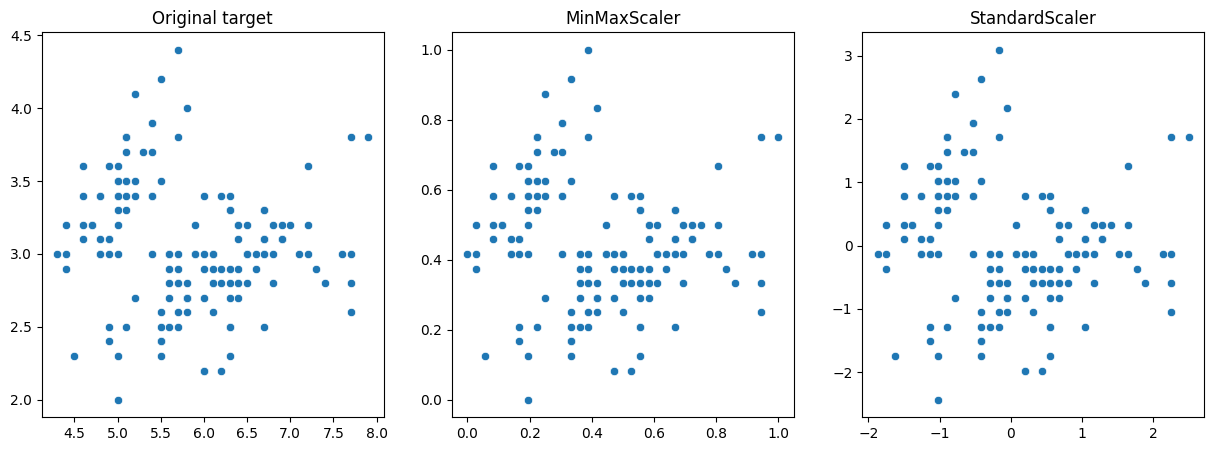

In [ ]:
# La forma de las distribuciones no cambia.
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original target
sns.scatterplot(x = X[:, 0], y = X[:, 1], ax=axes[0])
axes[0].set_title("Original target")

# MinMaxScaler
sns.scatterplot(x = X_minmax[:, 0], y = X_minmax[:, 1], ax=axes[1])
axes[1].set_title("MinMaxScaler")

# StandardScaler
sns.scatterplot(x = X_std[:, 0], y = X_std[:, 1], ax=axes[2])
axes[2].set_title("StandardScaler");

<a id="feat_reduc"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# 15. Feature Reduction
<a href="#feat_red_prelim"><p href="#feat_red_prelim">Ver apartado 6</p></a>

<a id="choose_metric"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# 16. Escoger métrica del modelo
Por desgracia los modelos no son perfectos y siempre cometen cierto error. De no ser así, probablemente no sería necesario utilizar Machine Learning para solucionar el problema y tengamos que acudir a soluciones más sencillas.

Por tanto, tendremos que definir una métrica para evaluar el comportamiento del modelo por dos motivos:
1. Primero, para probar varios modelos y poder **comparar** entre ellos cuál es el mejor
2. Segundo, para presentar **resultados del modelo**.

Prácticamente todas las métricas tratadas en este notebook están implementadas en `sklearn`, salvo MAPE. Consulta [la documentación](https://scikit-learn.org/stable/modules/model_evaluation.html) para más información.

### 16.1 Métricas para clasificación

##### Accuracy
La métrica más habitual. Calcula el % de acierto teniendo en cuenta todas las clases del algoritmo de clasificación. Esta métrica es muy fácil de entender, pero no profundiza en el % de acierto de cada clase, que puede ser algo interesante, dependiendo del problema que queramos tratar.

Accuracy = (TP + TN) / Total

##### Matriz de confusión
Confusión o *error matrix* es una tabla que describe el rendimiento de un modelo supervisado de Machine Learning en los datos de test, donde se desconocen los verdaderos valores. Se llama “matriz de confusión” porque hace que sea fácil detectar dónde el sistema está confundiendo dos clases.

* **True Positives (TP)**: cuando la clase real del punto de datos era 1 (Verdadero) y la predicha es también 1 (Verdadero)
* **Verdaderos Negativos (TN)**: cuando la clase real del punto de datos fue 0 (Falso) y el pronosticado también es 0 (Falso).
* **False Positives (FP)**: cuando la clase real del punto de datos era 0 (False) y el pronosticado es 1 (True).
* **False Negatives (FN)**: Cuando la clase real del punto de datos era 1 (Verdadero) y el valor predicho es 0 (Falso).

##### Recall o Sensibilidad
Los positivos que he clasificado bien vs todos los positivos que había. Métrica que se utiliza cuando queremos ahcer foco en minimizar los FN (Falsos Negativos). Claro ejemplo puede ser un test de COVID. No me importa tanto que haya FP, ya que las consecuencias son aislamientos preventivos, mientras que tener FN, es decir, personas con COVID, cuyo resultado del test es negativo, si es grave ya que pueden producir más contagios.

Recall = TP / (TP + FN)

##### Precision
De los que ha predicho como 1, cuántos en realidad ha acertado. Precision, a diferencia del recall, pone foco en minimizar los FP. Como ejemplo podemos poner un filtro anti-spam. Que se cuele algún correo de spam (FN) no me importa. Ahora bien, si se clasifica como spam un correo importante del jefe (FP) y no lo leemos, sí es más grave.

Precision = TP / (TP + FP)

##### Specifity
Es el número de ítems correctamente identificados como negativos sobre el total de negativos. Es lo opuesto al Recall.

Specifity = TN / (TN + FP)

##### F1-Score
Combinación de las métricas Precision y Recall. Esta métrica se utiliza para comparar clasificadores, ya que es algo más compleja de entender, pero muy útil cuando tenemos clasificadores cuyos valores de recall y precision se intercalan unos con otros y no está muy claro cuál es mejor, a no ser que tengamos claro que hay que centrarse o bien en el recall o en el precision. El rango del F1-score va de 0 a 1, como las métricas anteriores.

F1-score = 2 * Precision * Recall / (Precision + Recall)


##### Precision vs Recall plot
Recuerda que el modelo por defecto calcula las probabilidades de pertenecer a una clase, y que por defecto, si por ejemplo el clasificador es binario, y la probabilidad cae por encima del 50% se clasificaría como 1, como positivo. Ahora bien, modificar ese threshold cambia completamente la matrz de confusión. Si subimos el threshold somos más restrictivos con los 1s, y por tanto empezará a clasificar más valores como 0s y como FN. En cambio si lo bajamos, somos más permisivos con los 1s, los clasificaríamos casi todos, pero subirían los FP.

Es por ello que existen curvas como ROC o Precision vs Recall con las que podremos ver diferentes comportamientos del clasificador, teniendo en cuenta varios thresholds, y todo ello en una misma gráfica.

Mediante esta curva obtendremos el punto óptimo de precision vs recall. Para usar esta gráfica hay que comprender bien qué significan las métricas de precision y de recall

<img src="./img/precs_recall.png" alt="drawing" width="500"/>

##### ROC Curve/AUC
Similar a la anterior curva. Nos sirve para comparar el recall con FPR = FP/(FP + TN)

De esta curva podemos obtener una medida, que es el AUC (Area Under the Curve). El AUC cuanto más cercano a 1, mejor será el clasificador. Si la curva es una línea recta estaremos ante un clasificador muy malo, que no sería muy diferente a un clasificador aleatorio.

**Normalmente se usa la ROC curve cuando tenemos datasets balanceados, mientras que la curva precision-recall es más propia de datasets con una clase mayoritaria.**

<img src="./img/roc.png" alt="drawing" width="500"/>




Score del modelo (accuracy): 0.827
Accuracy score: 0.827
Recall score: 0.796
Precision score: 0.735
F1 score: 0.765
AUC: 0.82


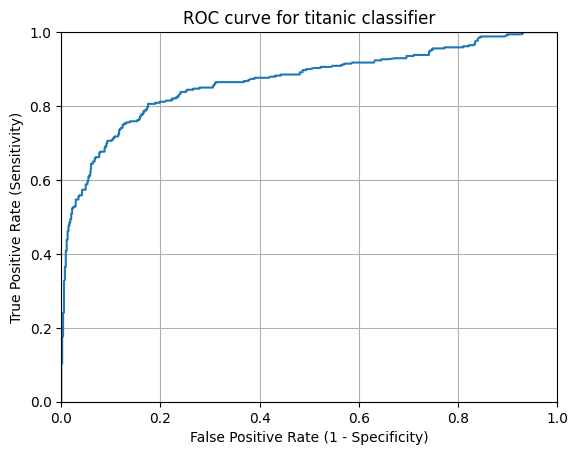

In [ ]:
# Metricas de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix

# Modelo rapido sin dividir en train/test ni ndada
titanic_df2 = titanic_df.drop(columns=['deck', 'alive']).copy()
titanic_df2 = titanic_df2.dropna()
titanic_df2 = pd.get_dummies(titanic_df2)

lr = LogisticRegression()
X = titanic_df2.iloc[:, 1:]
Y = titanic_df2.iloc[:, 0]

lr.fit(X, Y)
preds = lr.predict(X)

print("Score del modelo (accuracy):", round(lr.score(X, Y), 3))
print("Accuracy score:", round(accuracy_score(preds, Y), 3))
print("Recall score:", round(recall_score(preds, Y), 3))
print("Precision score:", round(precision_score(preds, Y), 3))
print("F1 score:", round(f1_score(preds, Y), 3))
print("AUC:", round(roc_auc_score(preds, Y), 3))


y_pred_prob = lr.predict_proba(X)[:, 1]
fpr, tpr, thresholds = roc_curve(Y, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for titanic classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

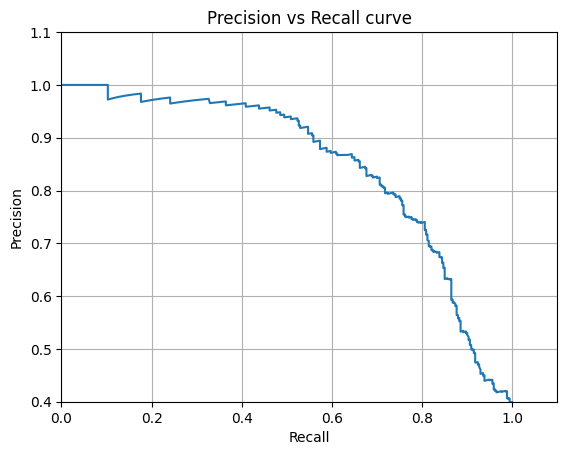

In [ ]:
precision, recall, thresholds = precision_recall_curve(Y, y_pred_prob)
plt.plot(recall, precision)
plt.xlim([0.0, 1.1])
plt.ylim([0.4, 1.1])
plt.title('Precision vs Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True);

[[485  64]
 [ 90 250]]


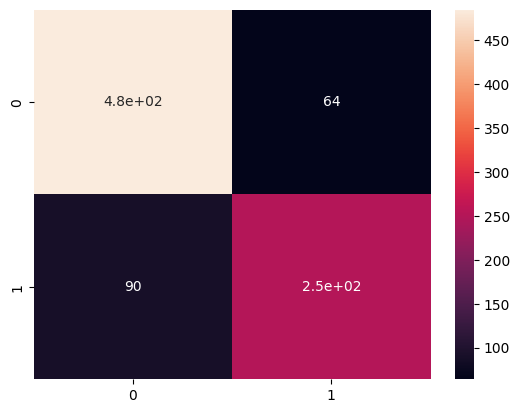

In [ ]:
c_matrix = confusion_matrix(Y, preds)
print(c_matrix)
import seaborn as sns
sns.heatmap(c_matrix, annot=True);

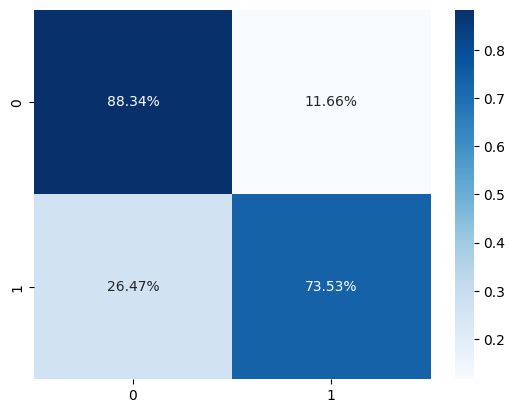

In [ ]:
sns.heatmap(confusion_matrix(Y, preds, normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');

### 16.2 Métricas para regresión

##### R^2
El R^2 es el coeficiente de determinación, representa el porcentaje de variación de la variable dependiente vs la independiente para un modelo lineal. Se mide entre 0 y 1. El problema es que R^2 no nos indica si mi modelo se ajusta bien a mis datos. Un buen modelo puede tener un R^2 bajo, e incluso un modelo mal entrenado podría llegar a tener un R^2 alto. [En este artículo tienes más detalles](https://statisticsbyjim.com/regression/interpret-r-squared-regression/#:~:text=R%2Dsquared%20evaluates%20the%20scatter,around%20the%20fitted%20regression%20line.&text=For%20the%20same%20data%20set,that%20a%20linear%20model%20explains.)

<img src="./img/r_squared.png" alt="drawing" width="230"/>

##### Mean Squared Error (MSE)
La media de los errores al cuadrado. ¿Por qué al cuadrado? Porque al calcular la suma no queremos que se nos cancelen unos errores con otros. ¿Qué esté al cuadrado nos sirve como medida de errores? Perfectamente, es más, esta métrica magnifica los errores grandes, por lo que si esos son los errores que no corregimos, seguiremos teniendo un MSE alto. 

MSE es una métrica muy utilizada ya que nos sirve para hacer foco en los errores grandes. Como los datos están al cuadrado, no suele ser una métrica para presentar resultados ya que los datos están "distorsionados". **Se utiliza mayormente para comparar modelos**.

<img src="./img/mse.jpg" alt="drawing" width="200"/>

##### Root Mean Squared Error (RMSE)
Igual que en el caso anterior, pero ahora en unidades del target. Esta métrica nos servirá tanto para comparar modelos, como para presentar resultados.

<img src="./img/rmse.png" alt="drawing" width="180"/>

##### Mean Absolute Error (MAE)
Muy util cuando queremos medir errores en las unidades de la variable. Te dice qué error puedes esperar en la predicción de la variable. Muy bueno cuando hay outliers, ya que lo vamos a ver claramente reflejado en la medida.

<img src="./img/mae.png" alt="drawing" width="200"/>

##### Mean Absolute Percentage Error (MAPE)
Es la única métrica acotada entre 0 y 1. Proporciona, en media, el % de error para cada punto respecto a su true label. Cuando queremos comparar modelos con diferentes targets, como por ejemplo en series temporales, las otras métricas no nos sirven porque van en función de las unidades de cada target, sin embargo mediante el MAPE podremos comparar con la misma unidad de medidas.

<img src="./img/mape.jpeg" alt="drawing" width="230"/>


In [ ]:
# Metricas de regresión
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

diamonds_df2 = pd.get_dummies(diamonds_df)

lr = LinearRegression()
X = diamonds_df2.drop(columns = ['price'])
Y = diamonds_df2['price']

lr.fit(X, Y)
preds = lr.predict(X)

print("Score del modelo (R^2):", round(lr.score(X, Y), 4))
print("R^2 score:", round(r2_score(preds, Y), 4))
print("MAE score:", round(mean_absolute_error(preds, Y), 4))
print("MSE score:", round(mean_squared_error(preds, Y), 4))
print("RMSE score:", round(np.sqrt(mean_squared_error(preds, Y)), 4))

def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print("MAPE score:", round(mean_absolute_percentage_error(preds, Y), 4))

Score del modelo (R^2): 0.9198
R^2 score: 0.9128
MAE score: 740.1156
MSE score: 1276882.8812
RMSE score: 1129.9924
MAPE score: 39.0661


<a id="choose_models"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# 17. Decidir qué modelos
Existen una gran cantidad de modelos que nos solventarán problemas de todo tipo. Ahora bien, ¿qué modelo se adapta mejor a los datos? Va a depender de los siguientes factores:

#### Volumen de datos
Lo ideal es cuantos más datos mejor, pero si tenemos:
1. **Pocos datos y muchas features**: elige algoritmos con alto bias y low variance. Algoritmos que tienen algo más de error, pero generalizan mejor. Linear regression, naive bayes, Linear SVM
2. **Muchos datos y pocas features**: elige algoritmos con low bias y high variance: KNN, Decission trees, resto de kernels de SVM

#### Accuracy vs interpretability
Lo más importante a la hora de elegir modelo. ¿Cuánto de explicable tiene que ser mi modelo? Si tenemos que dar una justificación detallada de las decisiones que toma mi modelo, necesitaré un algoritmo de caja blanca, de lo contrario, será un caja negra. Normalmente los algoritmos caja negra tienen una mejor precisión. El problema que presentan es que resulta muy difícil seguir la traza de los outputs del modelo y no sabemos muy bien qué está haciendo.

<img src="./img/choose_algorithm.png" alt="drawing" width="450"/>


#### Velocidad de entrenamiento
Normalmente los algoritmos más precisos suelen tener un tiempo de entrenamiento alto.
1. Rápidos: Logistic regression, linear models, naive bayes.
2. Lentos: SVM (por el tunning de hiperparámetros), RRNN, ensembles.

#### Relaciones lineales entre los datos
La importancia del análisis exploratorio. Si la relacion con el target es lineal, va a predecir bien un modelo lineal como logistic regression o SVM lineal. Si no tendremos que acudir a otros modelos que permitan modelar relaciones no lineales, como por ejemplo random forest, KNN, kernel SVM o redes neuronales.

¿Cómo comprobamos esto? Mediante el análisis exploratorio. Aunque otra opción sería entrenar una regresión lineal y analizar la aleatoriedad de los residuos. Deberían caer en una nube alrededor del 0, sin patrones tipo una parábola.

<img src="./img/choose_algorithm2.png" alt="drawing" width="650"/>

<a id="hyperparmeters"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# 18. Elegir hiperparámetros
Como ya sabes, cada dataset es de su padre y de su madre, y por tanto es imposible determinar el modelo con sus hiperparámetros que mejor se ajusten a los datos. Por tanto, tendremos que probar varias combinaciones. Por suerte `sklearn` tiene una función llamada GridSearchCV que permite probar varias combinaciones de una manera automatizada.

Empieza iterando unos pocos hiperparámetros y luego ve subiendo, según los resultados de esa ejecución.

En este apartado veremos posibles hiperparámetros a emplear en los algoritmos más utilizados.

In [ ]:
# REGRESION LOGISTICA
grid_logreg = {                   
                     "penalty": ["l1","l2"], # Regularizaciones L1 y L2.
                     "C": [0.1, 0.5, 1.0, 5.0], # Cuanta regularizacion queremos
                     
                     "max_iter": [50,100,500],  # Iteraciones del Gradient Descent. No suele impactar mucho
                                                # pero en ocasiones aparecen warnings diciendo que se aumente
                     
                     "solver": ["liblinear"]  # Suele ser el más rápido
                    }


# KNN
grid_neighbors = {"n_neighbors": [3,5,7,9,11],       # Pares acepta sklearn, pero se suele poner impares, por los empates
                  "weights": ["uniform","distance"]  # Ponderar o no las clasificaciones en 
                                                     # función de la inversa de la distancia a cada vecino
                  }

# ARBOL DE DECISION
grid_arbol = {"max_depth":list(range(1,10)) # Profundidades del árbol. Cuanto más profundo, mas posibilidades de overfitting,
                                            # pero  mas preciso en entrenamiento.
              }


# RANDOM FOREST
grid_random_forest = {"n_estimators": [120], # El Random Forest no suele empeorar por exceso de
                                             # estimadores. A partir de cierto numero no merece la pena
                                             # perder el tiempo ya que no mejora mucho más la precisión.
                                             # Entre 100 y 200 es una buena cifra

                     
                     "max_depth": [3,4,5,6,10,15,17], # No le afecta tanto el overfitting como al decissiontree.
                                                      # Podemos probar mayores profundidades
                      
                     "max_features": ["sqrt", 3, 4] # Numero de features que utiliza en cada split.
                                                    # cuanto más bajo, mejor generalizará y menos overfitting.
                                                    
                     }


# SVM
grid_svm = {"C": [0.01, 0.1, 0.3, 0.5, 1.0, 3, 5.0, 15, 30], # Parametro de regularizacion
            "kernel": ["linear","poly","rbf"], # Tipo de kernel, probar varios
            "degree": [2,3,4,5], # Cuantos grados queremos para el kernel polinomico
            "gamma": [0.001, 0.1, "auto", 1.0, 10.0, 30.0] # Coeficiente de regulaizacion para los kernels rbf, poly y sigmoid
           }


# GRADIENT BOOSTING
grid_gradient_boosting = {"loss": ["deviance"], # Deviance suele ir mejor.
                          "learning_rate": [0.05, 0.1, 0.2, 0.4, 0.5],  # Cuanto más alto, mas aporta cada nuevo arbol
                          
                          "n_estimators": [20,50,100,200], # Cuidado con poner muchos estiamdores ya que vamos a
                                                           # sobreajustar el modelo
                          
                          "max_depth": [1,2,3,4,5], # No es necesario poner una profundiad muy alta. Cada nuevo
                                                    # arbol va corrigiendo el error de los anteriores.
                          
                          
                          "max_features": ["sqrt", 3, 4], # Igual que en el random forest
                          }



<a id="pipelines"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# 19. Definimos pipelines y probamos
Ya tenemos los modelos y sus hiperparámetros elegidos, ahora solo queda configurar los pipelines para cada modelo. Por norma general, todo el preprocesado y limpieza de datos ya tiene que estar hecho en este punto, por lo que no será necesario cargar en exceso los pipelines. ¿Qué tienes que configurar en los pipelines?
1. **El modelo**: como último paso del pipeline. Puedes configurarle hiperparámetros que no vayas a iterar en la propia declaración del modelo.
2. **Escalados**: StandardScaler o MinMaxScaler. Menos en árboles.
3. **Feat. reduction**: prueba algun PCA o SelectKBest en algunos de los algoritmos, iterando sus hiperparámetros.
4. **Missings**: se suelen tratar antes, pero siempre tienes la opción de incluir un imputador de missings que afecte a todo el dataset.

**NOTA**: ten en cuenta que cuando se ejecute la validación cruzada, si imputaste missings con la media, por ejemplo, esta media está calculada sobre todo el conjunto de train, y en la validación cruzada (divide train en train+validation) estamos contaminando los datos de train (de la validacion cruzada) con los de validación. No es algo grave, pero lo correcto es para cada kfold calcular sus estadísticos de train y aplicarlos en train y validation. Esto lo hace solo GridSearchCV siempre y cuando el imputador de missings esté incluido en el pipeline. El problema es que hacer una configuración tan personalizada y adaptada a tus datos en el pipeline conlleva muchísimo trabajo y al final se suelen dejar los pipelines para operaciones de escalado y de feature selection.

En el siguiente código tendrás varios ejemplos de declaración de pipelines.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Si solo es el modelo, no hará falta meterlo en un pipeline
rand_forest = RandomForestClassifier()

svm = Pipeline([("scaler",StandardScaler()),
                ("selectkbest",SelectKBest()),
                ("svm",SVC())
               ])


reg_log = Pipeline([("imputer",SimpleImputer()),
                    ("scaler",StandardScaler()),
                    ("reglog",LogisticRegression())
                   ])

'''
Para iterar hiperparámetros de varios elementos del pipeline, le ponemos un nombre
a cada elemento en el pipeline, por ejemplo 'selectkbest' y 'svm', para luego en el
grid de hiperparametros identificar sus respectivos parametros mediante el nombre
que le hayamos puesto en el pipeline, dos guines bajos y el nombre del hiperparámetro.
'''

grid_random_forest = {"n_estimators": [120],
                     "max_depth": [3,4,5,6,10,15,17],
                     "max_features": ["sqrt", 3, 4]                          
                     }


svm_param = {                    
            'selectkbest__k': [1,2,3],
            'svm__C': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
            'svm__kernel': ["linear","poly","rbf"],
            'svm__coef0': [-10.,-1., 0., 0.1, 0.5, 1, 10, 100],
            'svm__gamma': ('scale', 'auto')
            }


reg_log_param = {    
                 "imputer__strategy": ['mean', 'median', 'most_frequent'],
                 "reglog__penalty": ["l1","l2"], 
                 "reglog__C": np.logspace(0, 4, 10)
                }

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
# Almaceno en una lista de tuplas los modelos (nombre que le pongo, el modelo, hiperparametros)
models = [('rand_forest', rand_forest, grid_random_forest),
         ('svm', svm, svm_param),
         ('reg_log', reg_log, reg_log_param)]

# Declaro en un diccionario los pipelines e hiperparametros
models_gridsearch = {}

for i in models:
    models_gridsearch[i[0]] = GridSearchCV(i[1],
                                          i[2],
                                          cv=10,
                                          scoring="accuracy",
                                          verbose=1,
                                          n_jobs=-1)
    
    models_gridsearch[i[0]].fit(X_train, y_train)

Fitting 10 folds for each of 21 candidates, totalling 210 fits
Fitting 10 folds for each of 1152 candidates, totalling 11520 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits


In [ ]:
best_grids = [(i, j.best_score_) for i, j in models_gridsearch.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

,Grid,Best score
2,reg_log,0.958333
1,svm,0.950000
0,rand_forest,0.941667


In [ ]:
# El mejor ha sido la regresion logistica. Ya esta entrenada con todo train
models_gridsearch['reg_log'].best_estimator_

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('reglog', LogisticRegression(C=7.742636826811269))])

In [ ]:
# La probamos en test
models_gridsearch['reg_log'].best_estimator_.score(X_test, y_test)

1.0

<a id="results"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
# 20. Resultados
Una vez elegidas las métricas y evaluados varios modelos, ya tendríamos los resultados del modelo. Sólo queda interpretarlos. Por desgracia este punto va a depender mucho del negocio.
1. **Evaluar los resutlados en test**: tenemos que comprobar que los resultados no difieren mucho del entrenamiento. Si son inferiores es debido a que el modelo está sobreentrenado (ver abajo para solucionarlo). Si son superiores es raro, probablemente porque no tengamos muchos datos. Habría que intentar coseguir más observaciones.
2. Evaluar los resultados respecto a las **necesidades de negocio**
3. **Almacenar** todas las muestras utilizadas en el entrenamiento, así como los scripts y el propio modelo entrenado. La puesta en producción no es el objetivo a cubrir en este notebook.
4. Elegir y evaluar la/las métrica/s con las que **presentaremos los resultados del modelo**. No tenemos por qué elegir la misma métrica utilizada en la búsqueda del mejor modelo, ya que no siempre es la más entendible: MSE o AUC.

#### ¿Qué hacer si tenemos overfitting?
Posibles opciones para reducir el overfitting
1. **Cross validation**: si hemos hecho bien el paso anterior, el cross validation es la mejor técnica para evitar el overfitting.
2. **Entrenar con más datos**: no quitar datos a test, sino intentar conseguir más datos.
3. **Eliminar features**: PCA o un algoritmo de feature selection podría ser una buena solución
4. **Max depth**: reducirlo si estamos con árboles
5. **Regularización**: aumentarla en los modelos que permitan regulaización como regresiones lineales y SVM
6. **Ensembles**: sobretodo los algoritmos de bagging como el random forest no suelen sobreajustarse tanto.

In [ ]:
# Guardar el modelo
import pickle

with open('finished_model.model', "wb") as archivo_salida:
    pickle.dump(models_gridsearch['reg_log'].best_estimator_, archivo_salida)

In [ ]:
# Para volver a leer el modelo
with open('finished_model.model', "rb") as archivo_entrada:
    pipeline_importada = pickle.load(archivo_entrada)
    
print(pipeline_importada)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('reglog', LogisticRegression(C=7.742636826811269))])


In [ ]:
pd.DataFrame(data = pipeline_importada.predict(X_train)).to_csv('predicciones.csv')